# TOPIC

Wybranym polem badawczym jest analiza danych zdrowotnych, z naciskiem na predykcję liczby kroków rejestrowanych przez telefon komórkowy. Temat projektu koncentruje się na wykorzystaniu danych szeregów czasowych dotyczących kroków zapisanych w aplikacji zdrowia. 

In [238]:
import warnings
warnings.filterwarnings('ignore')

In [236]:
import xml.etree.ElementTree as ET
import requests
import pandas as pd
import plotly.express as px
from scipy.stats import f_oneway
from scipy.stats import ks_2samp
import numpy as np
import missingno as msno
import functions 
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_percentage_error

api_key = ''

## Acquire

Zbieranie danych: Zbierz dane z wiarygodnych źródeł (np. Kaggle, UCI, Web scraping, inne serwisy... ), które są
złożone, realistyczne i mają praktyczne zastosowania. Zabronione jest użycie syntetycznych lub zbyt
uproszczonych zbiorów danych. Również nie rozpatrujemy CV i NLP na tych zajęciach, więc prośba nie
wybierać tematów z tej dziedziny bez poprzedniej konsultacji .

In [ ]:
file_path = 'apple_health_export_data/export.xml'    
tree = ET.parse(file_path)
root = tree.getroot()

records = []
for record in root.findall('Record'):
    entry = {
        "sourceName": record.attrib.get("sourceName"),
        "type": record.attrib.get("type"),
        "creationDate": record.attrib.get("creationDate"),
        "startDate": record.attrib.get("startDate"),
        "endDate": record.attrib.get("endDate"),
        "value": record.attrib.get("value"),
        "unit": record.attrib.get("unit"),
    }
    records.append(entry)

health_data = pd.DataFrame(records)
health_data.to_csv('health_data.csv', index=False)

In [ ]:
health_data.head()

sourceName                               type  \
0                 iPhone     HKQuantityTypeIdentifierHeight   
1                 iPhone   HKQuantityTypeIdentifierBodyMass   
2                 Health   HKQuantityTypeIdentifierBodyMass   
3  Apple Watch (Zuzanna)  HKQuantityTypeIdentifierHeartRate   
4  Apple Watch (Zuzanna)  HKQuantityTypeIdentifierHeartRate   

                creationDate                  startDate  \
0  2020-02-01 13:16:57 +0100  2020-02-01 13:16:57 +0100   
1  2020-02-01 13:16:57 +0100  2020-02-01 13:16:57 +0100   
2  2024-06-08 09:13:17 +0100  2024-06-08 09:13:00 +0100   
3  2020-02-01 13:20:25 +0100  2020-02-01 13:17:59 +0100   
4  2020-02-01 13:29:35 +0100  2020-02-01 13:29:21 +0100   

                     endDate value       unit  
0  2020-02-01 13:16:57 +0100   168         cm  
1  2020-02-01 13:16:57 +0100    55         kg  
2  2024-06-08 09:13:00 +0100    50         kg  
3  2020-02-01 13:17:59 +0100    69  count/min  
4  2020-02-01 13:29:21 +0100    68  count/min

In [ ]:
health_data.groupby('type').size().sort_values(ascending=False)

type
HKQuantityTypeIdentifierActiveEnergyBurned                82235
HKQuantityTypeIdentifierDistanceWalkingRunning            65537
HKQuantityTypeIdentifierStepCount                         55403
HKQuantityTypeIdentifierBasalEnergyBurned                 42949
HKQuantityTypeIdentifierHeartRate                         31951
HKQuantityTypeIdentifierHeadphoneAudioExposure            29356
HKQuantityTypeIdentifierWalkingStepLength                  8889
HKQuantityTypeIdentifierWalkingSpeed                       8889
HKQuantityTypeIdentifierFlightsClimbed                     8494
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage     8014
HKQuantityTypeIdentifierAppleStandTime                     6290
HKQuantityTypeIdentifierAppleExerciseTime                  5873
HKQuantityTypeIdentifierWalkingAsymmetryPercentage         4826
HKQuantityTypeIdentifierBodyTemperature                    3868
HKCategoryTypeIdentifierSleepAnalysis                      3754
HKCategoryTypeIdentifierAppleStandH

In [ ]:
url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Warsaw,PL/2017-12-09/2024-12-31?unitGroup=metric&key={api_key}&include=days'

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    weather_data = pd.DataFrame(data['days'])
    weather_data.to_csv('weather_data.csv', index=False)
else:
    print(f"Error: {response.status_code}, {response.text}")

In [ ]:
weather_data.head()

datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2017-12-09     1512774000      2.2     -1.0   0.7           0.5   
1  2017-12-10     1512860400      2.7     -0.1   0.9          -0.3   
2  2017-12-11     1512946800      6.0     -1.0   3.5           3.4   
3  2017-12-12     1513033200     10.9      4.8   7.3          10.9   
4  2017-12-13     1513119600      4.7     -1.8   1.5           1.3   

   feelslikemin  feelslike  dew  humidity  ...  sunriseEpoch    sunset  \
0          -2.6       -1.3 -2.1      81.8  ...    1512801186  15:23:24   
1          -5.3       -3.0 -2.5      78.0  ...    1512887652  15:23:14   
2          -6.6       -0.3 -0.2      77.2  ...    1512974116  15:23:06   
3           1.3        4.6  2.0      69.6  ...    1513060577  15:23:02   
4          -6.7       -1.7 -2.9      73.0  ...    1513147034  15:23:02   

   sunsetEpoch moonphase                    conditions  \
0   1512829404      0.70              Partially cloudy   
1   1512915794      0.75              Partially cloudy   
2   1513002186      0.77  Snow, Rain, Partially cloudy   
3   1513088582      0.80              Partially cloudy   
4   1513174982      0.84              Partially cloudy   

                                         description               icon  \
0                  Partly cloudy throughout the day.  partly-cloudy-day   
1                  Partly cloudy throughout the day.  partly-cloudy-day   
2  Partly cloudy throughout the day with rain or ...               rain   
3                  Partly cloudy throughout the day.  partly-cloudy-day   
4                  Partly cloudy throughout the day.  partly-cloudy-day   

                                            stations  source  tzoffset  
0  ['12376099999', 'EPWA', '12105699999', '123750...     obs       NaN  
1  ['12376099999', 'EPWA', '12105699999', '123750...     obs       NaN  
2  ['12376099999', 'EPWA', '12105699999', '123750...     obs       NaN  
3  ['12376099999', 'EPWA', '12105699999', '123750...     obs       NaN  
4  ['12376099999', 'EPWA', '12105699999', '123750...     obs       NaN  

[5 rows x 36 columns]

In [ ]:
weather_data.columns

Index(['datetime', 'datetimeEpoch', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'sunrise', 'sunriseEpoch', 'sunset', 'sunsetEpoch', 'moonphase',
       'conditions', 'description', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

## Cleaning

Czyszczenie danych: Radzenie sobie z brakującymi wartościami, wartościami odstającymi i przygotowanie danych
do analizy.

## steps

In [3]:
health_data = pd.read_csv('health_data.csv', low_memory=False)

In [4]:
steps = health_data[(health_data['sourceName'].isin(['iPhone', 'iPhone (Zuzanna)'])) & (health_data['type'] == 'HKQuantityTypeIdentifierStepCount')][['creationDate', 'value']].reset_index(drop=True)
steps['creationDate'] = pd.to_datetime(steps['creationDate']).dt.normalize().dt.tz_localize(None)
steps['value'] = steps['value'].astype(int)  
steps = steps.rename(columns={'creationDate': 'date'})
steps = steps.groupby('date').sum().reset_index()
date_range = pd.date_range(start="2017-12-09", end="2024-12-31", freq='D')
dates_df = pd.DataFrame(date_range, columns=['date'])
steps = pd.merge(dates_df, steps, on='date', how='left')
steps.head()

date   value
0 2017-12-09   617.0
1 2017-12-10  1325.0
2 2017-12-11  2559.0
3 2017-12-12  7467.0
4 2017-12-13  4866.0

In [5]:
functions.check_df(df=steps)

##################### SHAPE #####################
(2580, 2)
##################### TYPES #####################
date     datetime64[ns]
value           float64
dtype: object
##################### HEAD #####################
        date   value
0 2017-12-09   617.0
1 2017-12-10  1325.0
2 2017-12-11  2559.0
3 2017-12-12  7467.0
4 2017-12-13  4866.0
##################### TAIL #####################
           date  value
2575 2024-12-27   73.0
2576 2024-12-28  230.0
2577 2024-12-29   41.0
2578 2024-12-30  169.0
2579 2024-12-31  749.0
##################### N/A #####################
date      0
value    54
dtype: int64


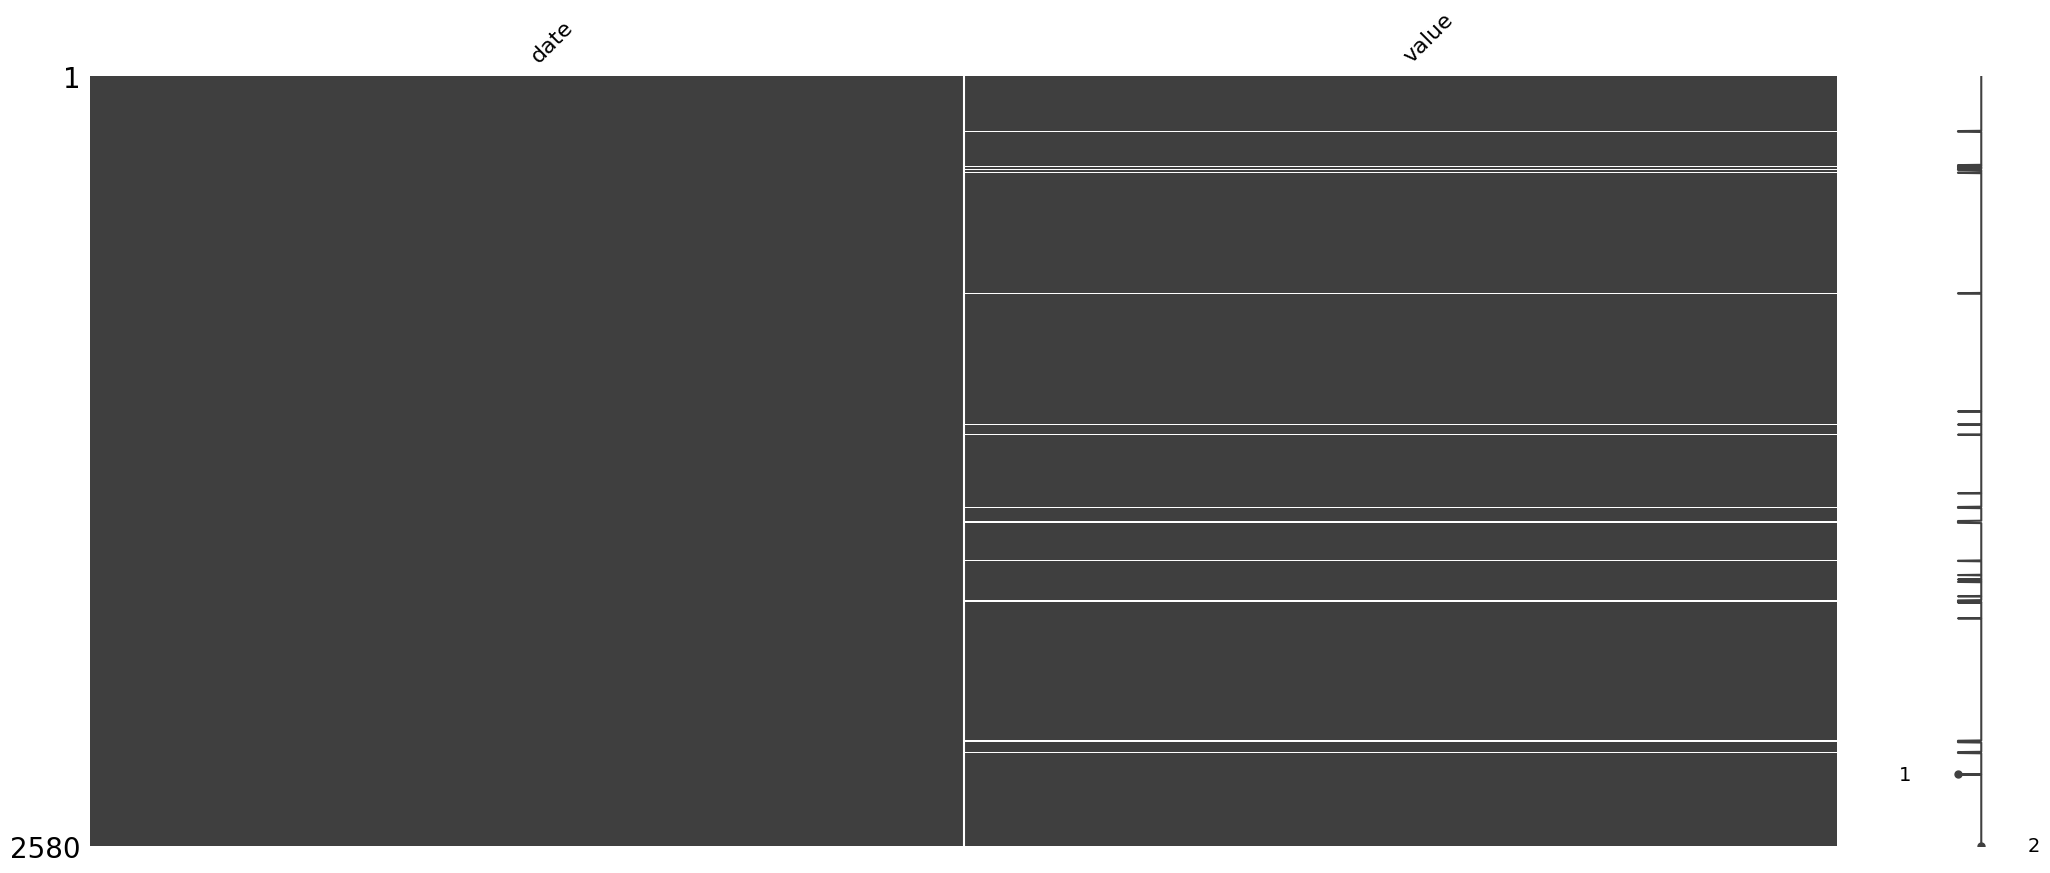

In [6]:
msno.matrix(steps);

In [7]:
functions.plot_column_distribution(steps, 'value', 'test')

Statystyki dla kolumny 'value':
count     2526.000000
mean      3550.988915
std       4313.730680
min          1.000000
25%        413.000000
50%       1840.500000
75%       5358.250000
max      43670.000000
Name: value, dtype: float64


In [8]:
functions.outliers_summary(steps, 'value')

Łączna liczba wartości odstających: 100

Statystyki dla wartości odstających:
count      100.000000
mean     17212.520000
std       5007.313109
min      12787.000000
25%      13734.250000
50%      15824.000000
75%      18562.250000
max      43670.000000
Name: value, dtype: float64


In [9]:
steps_copy = functions.replace_outliers_and_nans(steps, 'value')
ks_stat, ks_p_value = ks_2samp(steps['value'].dropna(), steps_copy['value'].dropna())
print(f"Statystyka KS: {ks_stat}, P-value: {ks_p_value}")

Statystyka KS: 0.03991971864700142, P-value: 0.032952035506159924


In [10]:
steps = functions.replace_outliers_and_nans(steps, 'value')
functions.plot_column_distribution(steps, 'value', 'test')

Statystyki dla kolumny 'value':
count     2580.000000
mean      3005.323256
std       3224.145185
min          1.000000
25%        393.500000
50%       1707.500000
75%       4855.500000
max      12748.000000
Name: value, dtype: float64


## weather

* **cloudcover** – how much of the sky is covered in cloud ranging from 0-100%
* **conditions** – textual representation of the weather conditions. See Weather Data Conditions.
* **description** – longer text descriptions suitable for displaying in weather displays. The descriptions combine the main features of the weather for the day such as precipitation or amount of cloud cover. Daily descriptions are provided for historical and forecast days. When the timeline request includes the model forecast period, a seven day outlook description is provided at the root response level.
* **datetime** – ISO 8601 formatted date, time or datetime value indicating the date and time of the weather data in the local time zone of the requested location. See Dates and Times in the Weather API for more information.
* **datetimeEpoch** – number of seconds since 1st January 1970 in UTC time
* **tzoffset** – the time zone offset in hours. This will only occur in the data object if it is different from the global time zone offset.
* **dew** – dew point temperature
* **feelslike** – what the temperature feels like accounting for heat index or wind chill. Daily values are average values (mean) for the day.
* **feelslikemax** (day only) – maximum feels like temperature at the location.
* **feelslikemin** (day only) – minimum feels like temperature at the location.
* **hours** – array of hourly weather data objects. This is a child of each of the daily weather object when hours are selected.
* **humidity** – relative humidity in %
* **icon** – a fixed, machine readable summary that can be used to display an icon
* **moonphase** –  represents the fractional portion through the current moon lunation cycle ranging from 0 (the new moon) to 0.5 (the full moon) and back to 1 (the next new moon). See How to include sunrise, sunset, moon phase, moonrise and moonset data into your API requests
* **normal** – array of normal weather data values – Each weather data normal is an array of three values representing, in order, the minimum value over the statistical period, the mean value, and the maximum value over the statistical period.
* **offsetseconds** (hourly only) – time zone offset for this weather data object in seconds – This value may change for a location based on daylight saving time observation.
* **precip** – the amount of liquid precipitation that fell or is predicted to fall in the period. This includes the liquid-equivalent amount of any frozen precipitation such as snow or ice.
* **precipcover** (days only) – the proportion of hours where there was non-zero precipitation
* **precipprob** (forecast only) – the likelihood of measurable precipitation ranging from 0% to 100%
* **preciptype** – an array indicating the type(s) of precipitation expected or that occurred. Possible values include rain, snow, freezingrain and ice.
* **pressure** – the sea level atmospheric or barometric pressure in millibars (or hectopascals)
* **snow** – the amount of snow that fell or is predicted to fall
* **snowdepth** – the depth of snow on the ground
* **source** –  the type of weather data used for this weather object. – Values include historical observation (“obs”), forecast (“fcst”), historical forecast (“histfcst”) or statistical forecast (“stats”). If multiple types are used in the same day, “comb” is used. Today a combination of historical observations and forecast data.
* **stations** (historical only) – the weather stations used when collecting an historical observation record
* **sunrise** (day only) – The formatted time of the sunrise (For example “2022-05-23T05:50:40”). See How to include sunrise, sunset, moon phase, moonrise and moonset data into your API requests
* **sunriseEpoch** – sunrise time specified as number of seconds since 1st January 1970 in UTC time
* **sunset** – The formatted time of the sunset (For example “2022-05-23T20:22:29”). See How to include sunrise, sunset, moon phase, moonrise and moonset data into your API requests
* **sunsetEpoch** – sunset time specified as number of seconds since 1st January 1970 in UTC time
* **moonrise** (day only, optional) – The formatted time of the moonrise (For example “2022-05-23T02:38:10”). See How to include sunrise, sunset, moon phase, moonrise and moonset data into your API requests
* **moonriseEpoch** (day only, optional) – moonrise time specified as number of seconds since 1st January 1970 in UTC time
* **moonset** (day only, optional) – The formatted time of the moonset (For example “2022-05-23T13:40:07”)
* **moonsetEpoch** (day only, optional) – moonset time specified as number of seconds since 1st January 1970 in UTC time
* **temp** – temperature at the location. Daily values are average values (mean) for the day.
* **tempmax** (day only) – maximum temperature at the location.
* **tempmin** (day only) – minimum temperature at the location.
* **uvindex** – a value between 0 and 10 indicating the level of ultra violet (UV) exposure for that hour or day. 10 represents high level of exposure, and 0 represents no exposure. The UV index is calculated based on amount of short wave solar radiation which in turn is a level the cloudiness, type of cloud, time of day, time of year and location altitude. Daily values represent the maximum value of the hourly values.
* **uvindex2** (optional, 5 day forecast only) – an alternative UV index element that uses the algorithms and models used by the US National Weather Service. In order to maintain backwards compatibility, this UV index element is deployed as a new, optional element ‘uvindex2’ and may be requested using the elements parameter.
* **visibility** – distance at which distant objects are visible
* **winddir** – direction from which the wind is blowing
* **windgust** – instantaneous wind speed at a location – May be empty if it is not significantly higher than the wind speed. Daily values are the maximum hourly value for the day.
* **windspeed** – the sustained wind speed measured as the average windspeed that occurs during the preceding one to two minutes. Daily values are the maximum hourly value for the day.
* **windspeedmax** (day only, optional) – maximum wind speed over the day.
* **windspeedmean** (day only , optional ) – average (mean) wind speed over the day.
* **windspeedmin** (day only , optional ) – minimum wind speed over the day.
* **solarradiation** – (W/m2) the solar radiation power at the instantaneous moment of the observation (or forecast prediction). See the full solar radiation data documentation and Wind and Solar Energy pages .
* **solarenergy** – (MJ /m2 ) indicates the total energy from the sun that builds up over an hour or day. See the full solar radiation data documentation and Wind and Solar Energy pages .
* **severerisk** (forecast only) – a value between 0 and 100 representing the risk of convective storms (e.g. thunderstorms, hail and tornadoes). Severe risk is a scaled measure that combines a variety of other fields such as the convective available potential energy (CAPE) and convective inhibition (CIN), predicted rain and wind. Typically, a severe risk value less than 30 indicates a low risk, between 30 and 70 a moderate risk and above 70 a high risk.
* **cape** (forecast only) – convective available potential energy. This is a numbering indicating amount of energy available to produce thunderstorms. A higher values indicates a more unstable atmosphere capable of creating stronger storms. Values lower than 1000 J/kg indicate generally low instability, between 1000-2500 J/kg medium instability and 2500-4000 J/kg high instability. Values greater than 4000 J/kg indicating an extremely unstable atmosphere.
* **cin** (forecast only) – convective inhibition. A number representing the level of atmospheric tendency to prevent instability and therefore prevent thunderstorms.
* **degreedays** (day only) – optional elements indicating the number of degree days for this date. See the degree days API for more information on degree days. To turn degree days and degree day accumulation on, use the elements parameter. For example, elements=datetime,tempmax,tempmin,degreedays,accdegreedays.

In [11]:
weather_data = pd.read_csv('weather_data.csv')

In [12]:
weather = weather_data[['datetime', 'temp', 'tempmax', 'tempmin', 'feelslike', 'humidity', 'precip', 'precipprob', 'precipcover', 'windspeed', 'windgust', 'cloudcover', 'visibility',  'uvindex', 'solarradiation', 'snow', 'snowdepth']].rename(columns={'datetime': 'date'})
weather.date = pd.to_datetime(weather.date)
weather

date  temp  tempmax  tempmin  feelslike  humidity  precip  \
0    2017-12-09   0.7      2.2     -1.0       -1.3      81.8   0.000   
1    2017-12-10   0.9      2.7     -0.1       -3.0      78.0   0.000   
2    2017-12-11   3.5      6.0     -1.0       -0.3      77.2   0.676   
3    2017-12-12   7.3     10.9      4.8        4.6      69.6   0.000   
4    2017-12-13   1.5      4.7     -1.8       -1.7      73.0   0.000   
...         ...   ...      ...      ...        ...       ...     ...   
2575 2024-12-27   1.1      2.1     -0.1        0.1      97.8   0.000   
2576 2024-12-28   0.8      1.9      0.0        0.3      97.9   0.000   
2577 2024-12-29   2.2      3.9      0.4        0.5      96.4   0.000   
2578 2024-12-30   0.9      2.0      0.0       -3.7      96.8   0.000   
2579 2024-12-31   1.1      2.5     -1.1       -2.8      92.0   0.000   

      precipprob  precipcover  windspeed  windgust  cloudcover  visibility  \
0            0.0         0.00       14.5      28.4        71.9        12.3   
1            0.0         0.00       20.3      40.0        77.7        14.1   
2          100.0         8.33       21.1      43.2        81.6        17.0   
3            0.0         0.00       26.5      51.2        78.7        17.7   
4            0.0         0.00       20.4      38.5        59.3        15.4   
...          ...          ...        ...       ...         ...         ...   
2575         0.0         0.00        8.4      14.8        99.1         3.1   
2576         0.0         0.00        7.4      13.3       100.0         4.2   
2577         0.0         0.00       18.5      32.4        86.4         3.8   
2578         0.0         0.00       23.4     158.4       100.0         5.5   
2579         0.0         0.00       27.4      50.5        76.3         8.5   

      uvindex  solarradiation  snow  snowdepth  
0         1.0            28.6   0.0        0.1  
1         1.0            25.4   0.0        0.1  
2         1.0            16.9   0.0        0.1  
3         2.0            21.1   0.0        0.1  
4         1.0            24.4   0.0        0.2  
...       ...             ...   ...        ...  
2575      1.0            11.8   0.0        0.0  
2576      0.0             5.7   0.0        0.0  
2577      1.0            16.0   0.0        0.0  
2578      0.0             3.2   0.0        0.0  
2579      1.0             8.7   0.0        0.0  

[2580 rows x 17 columns]

In [13]:
functions.check_df(weather)

##################### SHAPE #####################
(2580, 17)
##################### TYPES #####################
date              datetime64[ns]
temp                     float64
tempmax                  float64
tempmin                  float64
feelslike                float64
humidity                 float64
precip                   float64
precipprob               float64
precipcover              float64
windspeed                float64
windgust                 float64
cloudcover               float64
visibility               float64
uvindex                  float64
solarradiation           float64
snow                     float64
snowdepth                float64
dtype: object
##################### HEAD #####################
        date  temp  tempmax  tempmin  feelslike  humidity  precip  precipprob  \
0 2017-12-09   0.7      2.2     -1.0       -1.3      81.8   0.000         0.0   
1 2017-12-10   0.9      2.7     -0.1       -3.0      78.0   0.000         0.0   
2 2017-12-11   3.5    

In [14]:
numeric_columns = weather.select_dtypes(include='number').columns[1:]
df_numeric = weather[numeric_columns]
df_long = df_numeric.melt(var_name='Variable', value_name='Value')
fig = px.box(df_long, x='Variable', y='Value', title="Boxplot Zbiorczy dla Zmiennych Numerycznych")
fig.update_layout(xaxis_title="Zmienne", yaxis_title="Wartości")
fig.show()

print("Statystyki dla zmiennych numerycznych:")
df_numeric.describe()

Statystyki dla zmiennych numerycznych:


tempmax      tempmin    feelslike     humidity       precip  \
count  2580.000000  2580.000000  2580.000000  2580.000000  2580.000000   
mean     14.440078     6.259031     8.952597    73.348256     1.530900   
std       9.668886     7.382871     9.891438    14.553708     5.410254   
min     -13.200000   -20.100000   -19.300000    29.000000     0.000000   
25%       6.275000     0.500000     0.700000    63.300000     0.000000   
50%      14.400000     6.000000     9.400000    74.900000     0.000000   
75%      22.800000    12.400000    17.800000    85.125000     0.869000   
max      35.600000    22.800000    28.800000    99.500000   115.900000   

        precipprob  precipcover    windspeed     windgust   cloudcover  \
count  2580.000000  2580.000000  2580.000000  2580.000000  2580.000000   
mean     46.356589     5.717504    19.880078    37.957597    61.192674   
std      49.876746    11.276712     6.731558    14.311815    23.365275   
min       0.000000     0.000000     4.600000    10.100000     0.000000   
25%       0.000000     0.000000    15.100000    28.800000    46.000000   
50%       0.000000     0.000000    19.000000    36.200000    63.750000   
75%     100.000000     4.170000    23.900000    45.000000    79.800000   
max     100.000000    91.670000    52.000000   201.600000   100.000000   

        visibility      uvindex  solarradiation         snow    snowdepth  
count  2580.000000  2580.000000     2580.000000  2580.000000  2580.000000  
mean     14.324767     4.106589      117.476822     0.105116     0.404225  
std       4.164520     2.672051       89.531992     0.691210     1.585926  
min       1.200000     0.000000        3.200000     0.000000     0.000000  
25%      11.700000     2.000000       31.775000     0.000000     0.000000  
50%      15.600000     4.000000       98.800000     0.000000     0.000000  
75%      17.800000     6.000000      191.325000     0.000000     0.000000  
max      21.900000    10.000000      342.900000    15.000000    15.600000

In [15]:
steps = functions.create_date_features(steps, 'date')
steps

date   value  month  day_of_month  day_of_year  day_of_week  year  \
0    2017-12-09   617.0     12             9          343            6  2017   
1    2017-12-10  1325.0     12            10          344            7  2017   
2    2017-12-11  2559.0     12            11          345            1  2017   
3    2017-12-12  7467.0     12            12          346            2  2017   
4    2017-12-13  4866.0     12            13          347            3  2017   
...         ...     ...    ...           ...          ...          ...   ...   
2575 2024-12-27    73.0     12            27          362            5  2024   
2576 2024-12-28   230.0     12            28          363            6  2024   
2577 2024-12-29    41.0     12            29          364            7  2024   
2578 2024-12-30   169.0     12            30          365            1  2024   
2579 2024-12-31   749.0     12            31          366            2  2024   

      is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  \
0           1               0             0        4                 0   
1           1               0             0        4                 0   
2           0               0             0        4                 0   
3           0               0             0        4                 0   
4           0               0             0        4                 0   
...       ...             ...           ...      ...               ...   
2575        1               0             0        4                 0   
2576        1               0             0        4                 0   
2577        1               0             0        4                 0   
2578        0               0             0        4                 0   
2579        0               0             1        4                 0   

      is_quarter_end  is_year_start  is_year_end  
0                  0              0            0  
1                  0              0            0  
2                  0              0            0  
3                  0              0            0  
4                  0              0            0  
...              ...            ...          ...  
2575               0              0            0  
2576               0              0            0  
2577               0              0            0  
2578               0              0            0  
2579               1              0            1  

[2580 rows x 15 columns]

In [16]:
df = pd.merge(steps, weather, how='left', on='date')
df

date   value  month  day_of_month  day_of_year  day_of_week  year  \
0    2017-12-09   617.0     12             9          343            6  2017   
1    2017-12-10  1325.0     12            10          344            7  2017   
2    2017-12-11  2559.0     12            11          345            1  2017   
3    2017-12-12  7467.0     12            12          346            2  2017   
4    2017-12-13  4866.0     12            13          347            3  2017   
...         ...     ...    ...           ...          ...          ...   ...   
2575 2024-12-27    73.0     12            27          362            5  2024   
2576 2024-12-28   230.0     12            28          363            6  2024   
2577 2024-12-29    41.0     12            29          364            7  2024   
2578 2024-12-30   169.0     12            30          365            1  2024   
2579 2024-12-31   749.0     12            31          366            2  2024   

      is_wknd  is_month_start  is_month_end  ...  precipprob  precipcover  \
0           1               0             0  ...         0.0         0.00   
1           1               0             0  ...         0.0         0.00   
2           0               0             0  ...       100.0         8.33   
3           0               0             0  ...         0.0         0.00   
4           0               0             0  ...         0.0         0.00   
...       ...             ...           ...  ...         ...          ...   
2575        1               0             0  ...         0.0         0.00   
2576        1               0             0  ...         0.0         0.00   
2577        1               0             0  ...         0.0         0.00   
2578        0               0             0  ...         0.0         0.00   
2579        0               0             1  ...         0.0         0.00   

      windspeed  windgust  cloudcover  visibility  uvindex  solarradiation  \
0          14.5      28.4        71.9        12.3      1.0            28.6   
1          20.3      40.0        77.7        14.1      1.0            25.4   
2          21.1      43.2        81.6        17.0      1.0            16.9   
3          26.5      51.2        78.7        17.7      2.0            21.1   
4          20.4      38.5        59.3        15.4      1.0            24.4   
...         ...       ...         ...         ...      ...             ...   
2575        8.4      14.8        99.1         3.1      1.0            11.8   
2576        7.4      13.3       100.0         4.2      0.0             5.7   
2577       18.5      32.4        86.4         3.8      1.0            16.0   
2578       23.4     158.4       100.0         5.5      0.0             3.2   
2579       27.4      50.5        76.3         8.5      1.0             8.7   

      snow  snowdepth  
0      0.0        0.1  
1      0.0        0.1  
2      0.0        0.1  
3      0.0        0.1  
4      0.0        0.2  
...    ...        ...  
2575   0.0        0.0  
2576   0.0        0.0  
2577   0.0        0.0  
2578   0.0        0.0  
2579   0.0        0.0  

[2580 rows x 31 columns]

# Analysis

Analiza danych: Przeprowadź dokładną analizę, koncentrując się na odkrywaniu zależności, trendów i wzorców.
Metody analizy muszą być dostosowane do typu danych.
Przykłady:
- Dla szeregów czasowych, mogą pasować takie metody jak średnie kroczące, metody dekompozycji, itd.
- Dla danych kategorycznych, można użyć jak tabele krzyżowe, test chi-kwadrat, itd.
- Dla danych ciągłych, możemy użyć analizę korelacji, regresję, itd.
(to są tylko przykłady ogólne, w konkretnych przypadkach mogą być użyte inne metody z uzasadnieniem)

1. wizualizacja szeregu czasowego
2. sprawdzenie stancjonarnosc - test adfullera
3. dekompozycja szeregu czasowego
4. acf/pacf  

## analiza szeregu czasowe

In [61]:
df.head()

date   value  month  year  day_of_week  is_wknd  temp  humidity  \
0 2017-12-09   617.0     12  2017            6        1   0.7      81.8   
1 2017-12-10  1325.0     12  2017            7        1   0.9      78.0   
2 2017-12-11  2559.0     12  2017            1        0   3.5      77.2   
3 2017-12-12  7467.0     12  2017            2        0   7.3      69.6   
4 2017-12-13  4866.0     12  2017            3        0   1.5      73.0   

   precipcover  windspeed  cloudcover  visibility  solarradiation  day season  \
0         0.00       14.5        71.9        12.3            28.6    9  zimne   
1         0.00       20.3        77.7        14.1            25.4   10  zimne   
2         8.33       21.1        81.6        17.0            16.9   11  zimne   
3         0.00       26.5        78.7        17.7            21.1   12  zimne   
4         0.00       20.4        59.3        15.4            24.4   13  zimne   

  cloudcover_category precipcover_category month_year  
0           pochmurne           bez opadów    2017-12  
1           pochmurne           bez opadów    2017-12  
2           pochmurne            z opadami    2017-12  
3           pochmurne           bez opadów    2017-12  
4        niepochmurne           bez opadów    2017-12

In [65]:
fig = px.line(df, y='value', x='date', title="Szereg czasowy")

# Dostosowanie wykresu
fig.update_layout(width=1200, height=500)
fig.update_xaxes(title_text='Data', tickformat='%Y-%m')  # Formatowanie osi X na 'Rok-Miesiąc'

# Wyświetlenie wykresu
fig.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.value)

print("Wyniki testu ADF:")
print(f"Statystyka testu: {result[0]}")
print(f"P-wartość: {result[1]}")
print(f"Liczba opóźnień: {result[2]}")
print(f"Licza punktów w próbce: {result[3]}")
print(f"Skala krytyczna (1%): {result[4]['1%']}")
print(f"Skala krytyczna (5%): {result[4]['5%']}")
print(f"Skala krytyczna (10%): {result[4]['10%']}")
print(result[1])

if result[1] < 0.05:
    print("\nWynik testu ADF sugeruje, że szereg czasowy jest stacjonarny.")
else:
    print("\nWynik testu ADF sugeruje, że szereg czasowy nie jest stacjonarny.")

Wyniki testu ADF:
Statystyka testu: -5.14138286436765
P-wartość: 1.1567468603250388e-05
Liczba opóźnień: 27
Licza punktów w próbce: 2552
Skala krytyczna (1%): -3.4329150038333975
Skala krytyczna (5%): -2.862673215219002
Skala krytyczna (10%): -2.56737325262748
1.1567468603250388e-05

Wynik testu ADF sugeruje, że szereg czasowy jest stacjonarny.


In [ ]:
functions.plot_seasonal_decompose(df, 'value')

In [ ]:
functions.plot_autocorrelation(df.value, alpha=0.01, show_pacf=False)
functions.plot_autocorrelation(df.value, alpha=0.01, show_pacf=True)


## analiza z innymi zmiennymi

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2580 non-null   datetime64[ns]
 1   value             2580 non-null   float64       
 2   month             2580 non-null   int32         
 3   day_of_month      2580 non-null   int32         
 4   day_of_year       2580 non-null   int32         
 5   day_of_week       2580 non-null   int32         
 6   year              2580 non-null   int32         
 7   is_wknd           2580 non-null   int32         
 8   is_month_start    2580 non-null   int64         
 9   is_month_end      2580 non-null   int64         
 10  quarter           2580 non-null   int32         
 11  is_quarter_start  2580 non-null   int64         
 12  is_quarter_end    2580 non-null   int64         
 13  is_year_start     2580 non-null   int64         
 14  is_year_end       2580 n

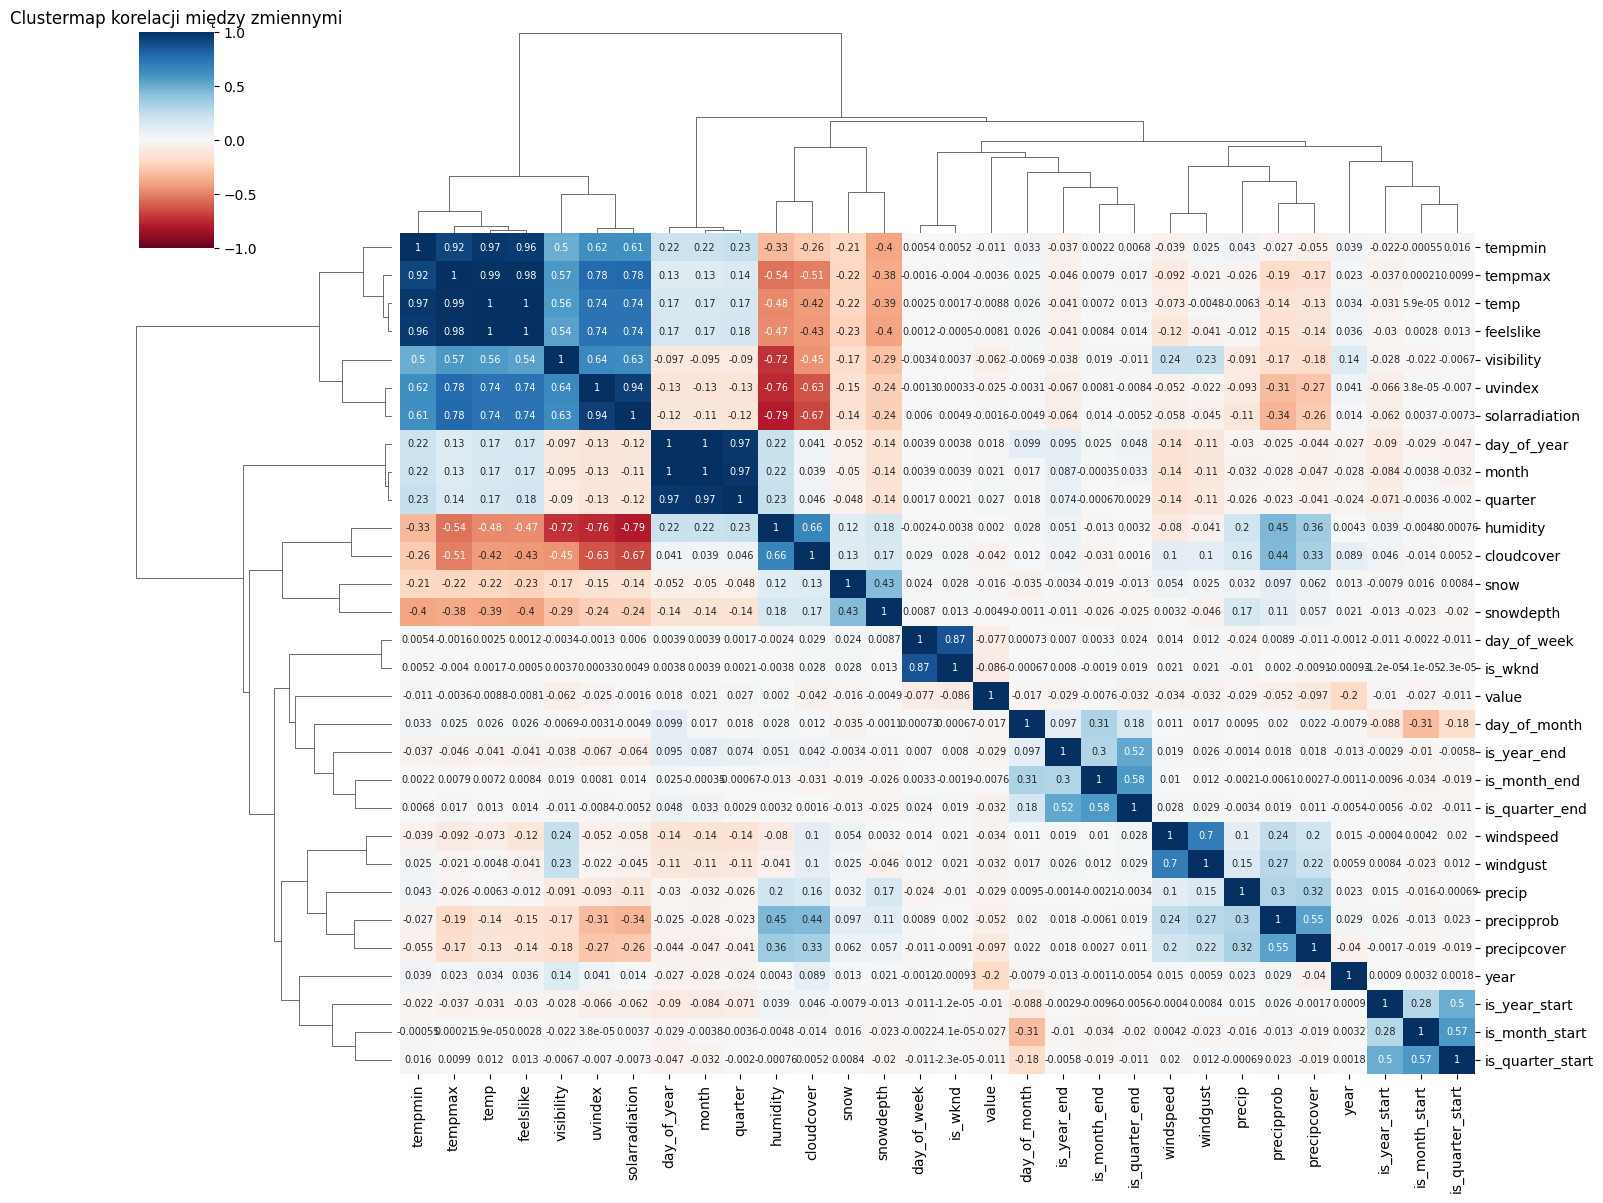

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór zmiennych numerycznych (pomijając kolumnę 'date')
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).drop(columns=['date'], errors='ignore')

# Obliczenie macierzy korelacji
correlations = numeric_columns.corr()

# Wizualizacja clustermap
sns.clustermap(correlations, 
               method="complete",   # Metoda grupowania
               cmap='RdBu',         # Kolorystyka (RdBu dla wartości dodatnich i ujemnych)
               annot=True,          # Adnotacje wartości korelacji
               annot_kws={"size": 7},# Rozmiar adnotacji
               vmin=-1, vmax=1,      # Zakres wartości korelacji
               figsize=(15, 12))     # Rozmiar wykresu

plt.title('Clustermap korelacji między zmiennymi')
plt.show()


In [45]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression

def analyze_and_visualize_nonlinear(df, target='value'):

    features = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [f for f in features if f != target]
    
    results = {}

    for feature in features:
        feature_data = df[feature].copy()
        target_data = df[target].copy()

        results[feature] = {
            'original': stats.spearmanr(feature_data, target_data)[0]
        }

        mi_score = mutual_info_regression(
            feature_data.values.reshape(-1, 1), 
            target_data, 
            discrete_features='auto'
        )[0]
        results[feature]['mutual_info'] = mi_score

        try:
            min_val = feature_data.min()

            log_data = np.log1p(feature_data - min_val + 1)
            results[feature]['log'] = stats.spearmanr(log_data, target_data)[0]

            results[feature]['square'] = stats.spearmanr(feature_data**2, target_data)[0]

            sqrt_data = np.sqrt(feature_data - min_val)
            results[feature]['sqrt'] = stats.spearmanr(sqrt_data, target_data)[0]

            inverse_data = 1 / (feature_data - min_val + 1)
            results[feature]['inverse'] = stats.spearmanr(inverse_data, target_data)[0]

        except:
            continue

    results_df = pd.DataFrame(results).T

    fig = go.Figure(data=go.Heatmap(
        z=results_df.values,
        x=results_df.columns,
        y=results_df.index,
        colorscale='Blues',
        text=np.round(results_df.values, 3),
        texttemplate='%{text}',
        textfont={"size": 10},
        hoverongaps=False
    ))

    fig.update_layout(
        title='Nonlinear Relationships Analysis',
        xaxis_title='Transformation Type',
        yaxis_title='Features',
        width=1000,
        height=max(400, len(features) * 25)
    )

    abs_corr = abs(results_df['original']).sort_values(ascending=False)
    mi_scores = results_df['mutual_info'].sort_values(ascending=False)

    return {
        'results': results_df,
        'heatmap': fig,
        'top_corr': abs_corr,
        'top_mi': mi_scores
    }


In [46]:

results = analyze_and_visualize_nonlinear(df, target='value')

print("\nTop correlations:")
print(results['top_corr'])
print("\nTop mutual information scores:")
print(results['top_mi'])
results['heatmap'].show()



Top correlations:
year                0.235995
precipcover         0.071316
cloudcover          0.065652
is_wknd             0.054757
precip              0.053086
day_of_week         0.052132
visibility          0.051338
precipprob          0.049923
windspeed           0.034928
snow                0.024559
is_year_end         0.023602
day_of_month        0.023043
tempmax             0.022032
quarter             0.018860
snowdepth           0.018574
feelslike           0.017108
solarradiation      0.016391
temp                0.015566
month               0.014675
humidity            0.013946
is_quarter_end      0.013289
day_of_year         0.011515
windgust            0.011378
is_month_start      0.011366
tempmin             0.009446
is_year_start       0.002356
uvindex             0.001295
is_month_end        0.001102
is_quarter_start    0.000427
Name: original, dtype: float64

Top mutual information scores:
year                0.107830
day_of_week         0.040299
day_of_year        

In [17]:
df = df[['date', 'value', 'month', 'year', 'day_of_week', 'is_wknd', 'temp',  'humidity', 'precipcover', 'windspeed', 'cloudcover','visibility',  'solarradiation']]
df

date   value  month  year  day_of_week  is_wknd  temp  humidity  \
0    2017-12-09   617.0     12  2017            6        1   0.7      81.8   
1    2017-12-10  1325.0     12  2017            7        1   0.9      78.0   
2    2017-12-11  2559.0     12  2017            1        0   3.5      77.2   
3    2017-12-12  7467.0     12  2017            2        0   7.3      69.6   
4    2017-12-13  4866.0     12  2017            3        0   1.5      73.0   
...         ...     ...    ...   ...          ...      ...   ...       ...   
2575 2024-12-27    73.0     12  2024            5        1   1.1      97.8   
2576 2024-12-28   230.0     12  2024            6        1   0.8      97.9   
2577 2024-12-29    41.0     12  2024            7        1   2.2      96.4   
2578 2024-12-30   169.0     12  2024            1        0   0.9      96.8   
2579 2024-12-31   749.0     12  2024            2        0   1.1      92.0   

      precipcover  windspeed  cloudcover  visibility  solarradiation  
0            0.00       14.5        71.9        12.3            28.6  
1            0.00       20.3        77.7        14.1            25.4  
2            8.33       21.1        81.6        17.0            16.9  
3            0.00       26.5        78.7        17.7            21.1  
4            0.00       20.4        59.3        15.4            24.4  
...           ...        ...         ...         ...             ...  
2575         0.00        8.4        99.1         3.1            11.8  
2576         0.00        7.4       100.0         4.2             5.7  
2577         0.00       18.5        86.4         3.8            16.0  
2578         0.00       23.4       100.0         5.5             3.2  
2579         0.00       27.4        76.3         8.5             8.7  

[2580 rows x 13 columns]

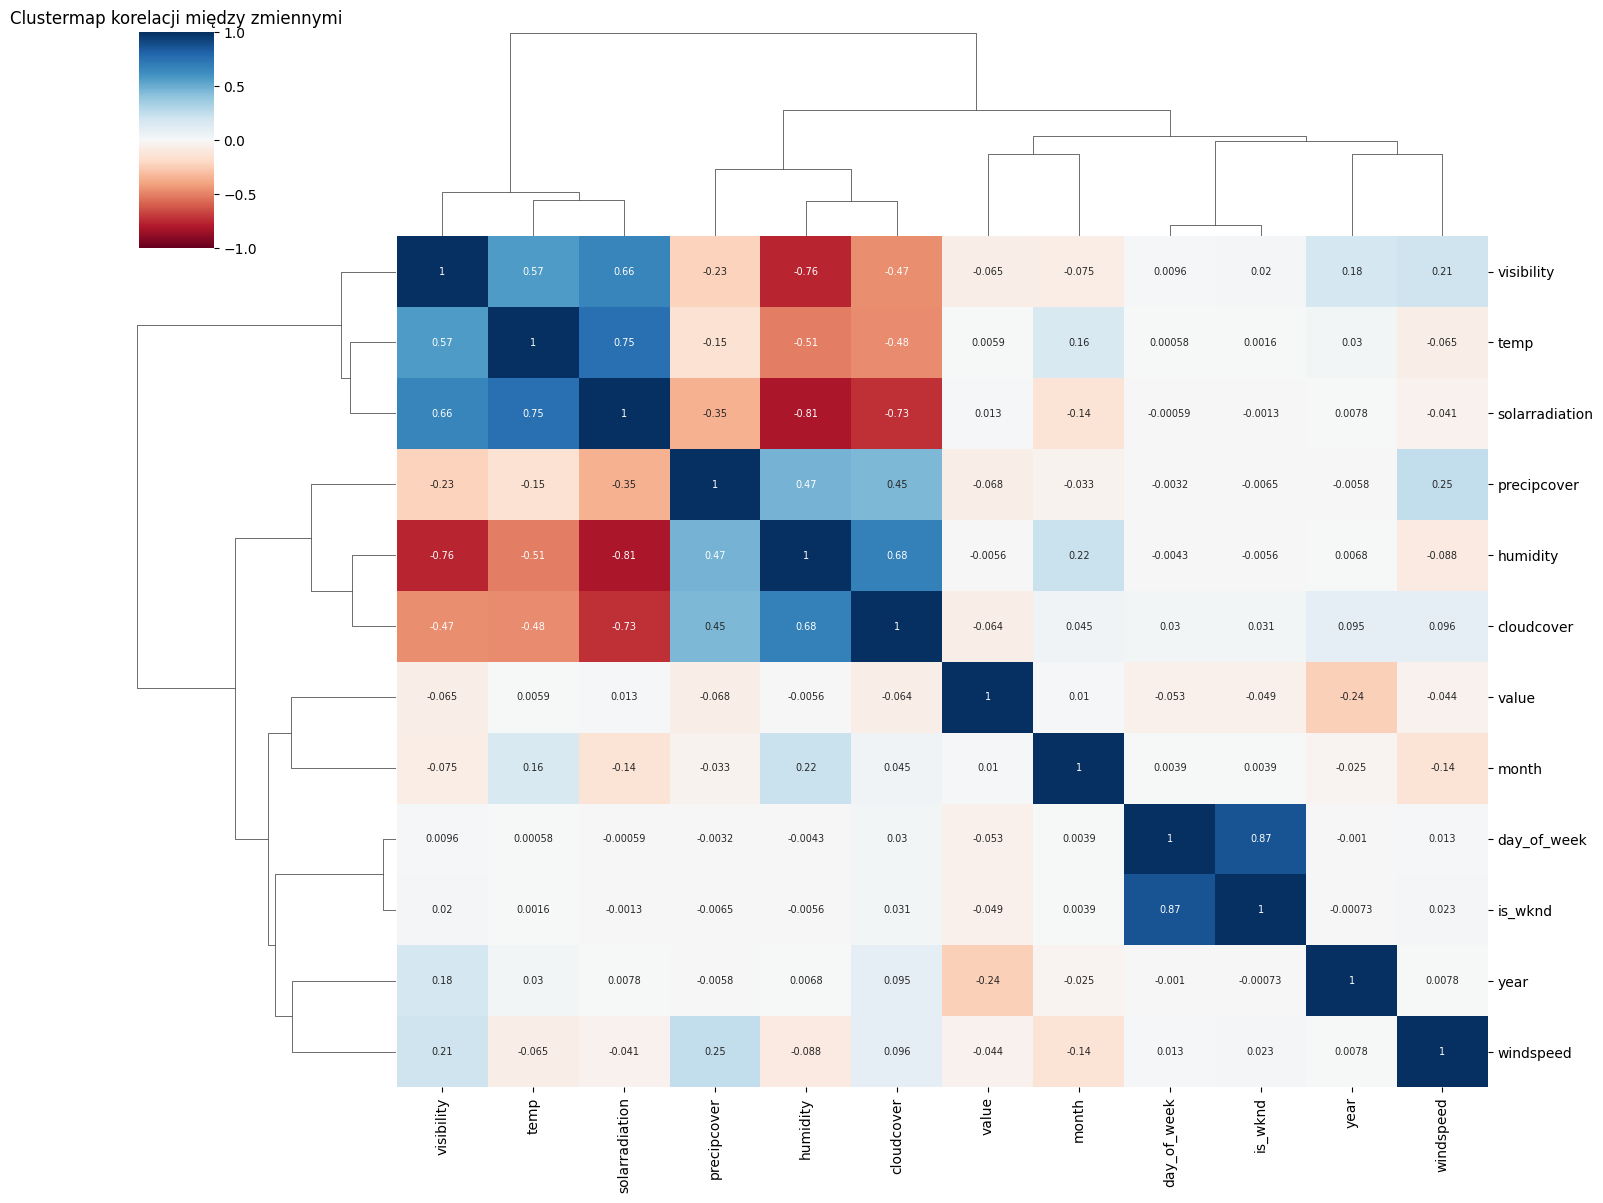

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wybór zmiennych numerycznych (pomijając kolumnę 'date')
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).drop(columns=['date'], errors='ignore')

# Obliczenie macierzy korelacji
correlations = numeric_columns.corr(method='spearman')

# Wizualizacja clustermap
sns.clustermap(correlations, 
               method="complete",   # Metoda grupowania
               cmap='RdBu',         # Kolorystyka (RdBu dla wartości dodatnich i ujemnych)
               annot=True,          # Adnotacje wartości korelacji
               annot_kws={"size": 7},# Rozmiar adnotacji
               vmin=-1, vmax=1,      # Zakres wartości korelacji
               figsize=(15, 12))     # Rozmiar wykresu

plt.title('Clustermap korelacji między zmiennymi')
plt.show()

### calendar

In [84]:

january_steps = df[df['month'] == 1]['value']
february_steps = df[df['month'] == 2]['value']
march_steps = df[df['month'] == 3]['value']
april_steps = df[df['month'] == 4]['value']
may_steps = df[df['month'] == 5]['value']
june_steps = df[df['month'] == 6]['value']
july_steps = df[df['month'] == 7]['value']
august_steps = df[df['month'] == 8]['value']
september_steps = df[df['month'] == 9]['value']
october_steps = df[df['month'] == 10]['value']
november_steps = df[df['month'] == 11]['value']
december_steps = df[df['month'] == 12]['value']

# Test Shapiro-Wilka dla miesięcznych danych
shapiro_january = stats.shapiro(january_steps)
shapiro_february = stats.shapiro(february_steps)
shapiro_march = stats.shapiro(march_steps)
shapiro_april = stats.shapiro(april_steps)
shapiro_may = stats.shapiro(may_steps)
shapiro_june = stats.shapiro(june_steps)
shapiro_july = stats.shapiro(july_steps)
shapiro_august = stats.shapiro(august_steps)
shapiro_september = stats.shapiro(september_steps)
shapiro_october = stats.shapiro(october_steps)
shapiro_november = stats.shapiro(november_steps)
shapiro_december = stats.shapiro(december_steps)

print(f"Test Shapiro-Wilka dla stycznia: p = {shapiro_january.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla lutego: p = {shapiro_february.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla marca: p = {shapiro_march.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla kwietnia: p = {shapiro_april.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla maja: p = {shapiro_may.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla czerwca: p = {shapiro_june.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla lipca: p = {shapiro_july.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla sierpnia: p = {shapiro_august.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla września: p = {shapiro_september.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla października: p = {shapiro_october.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla listopada: p = {shapiro_november.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla grudnia: p = {shapiro_december.pvalue:.4f}")

# Sprawdzenie normalności dla wszystkich miesięcznych danych
if all(p > 0.05 for p in [shapiro_january.pvalue, shapiro_february.pvalue, shapiro_march.pvalue,
                         shapiro_april.pvalue, shapiro_may.pvalue, shapiro_june.pvalue,
                         shapiro_july.pvalue, shapiro_august.pvalue, shapiro_september.pvalue,
                         shapiro_october.pvalue, shapiro_november.pvalue, shapiro_december.pvalue]):
    # Jeśli wszystkie miesięczne dane są normalne, wykonaj ANOVA
    f_stat, p_value = stats.f_oneway(january_steps, february_steps, march_steps, april_steps,
                                      may_steps, june_steps, july_steps, august_steps,
                                      september_steps, october_steps, november_steps, december_steps)
    test_used = "ANOVA (analiza wariancji)"
else:
    # Jeśli dane nie są normalne, użyj testu Kruskala-Wallisa (nieparametrycznego)
    h_stat, p_value = stats.kruskal(january_steps, february_steps, march_steps, april_steps,
                                     may_steps, june_steps, july_steps, august_steps,
                                     september_steps, october_steps, november_steps, december_steps)
    test_used = "Test Kruskala-Wallisa"

print(f"{test_used}: statystyka = {h_stat:.4f}, p-wartość = {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value < alpha:
    print("Różnice między miesiącami są statystycznie istotne (odrzucamy H0).")
else:
    print("Brak istotnych różnic między miesiącami (nie odrzucamy H0).")


Test Shapiro-Wilka dla stycznia: p = 0.0000
Test Shapiro-Wilka dla lutego: p = 0.0000
Test Shapiro-Wilka dla marca: p = 0.0000
Test Shapiro-Wilka dla kwietnia: p = 0.0000
Test Shapiro-Wilka dla maja: p = 0.0000
Test Shapiro-Wilka dla czerwca: p = 0.0000
Test Shapiro-Wilka dla lipca: p = 0.0000
Test Shapiro-Wilka dla sierpnia: p = 0.0000
Test Shapiro-Wilka dla września: p = 0.0000
Test Shapiro-Wilka dla października: p = 0.0000
Test Shapiro-Wilka dla listopada: p = 0.0000
Test Shapiro-Wilka dla grudnia: p = 0.0000
Test Kruskala-Wallisa: statystyka = 19.5715, p-wartość = 0.0516
Brak istotnych różnic między miesiącami (nie odrzucamy H0).


In [85]:


# Podział danych na grupy według dnia tygodnia
monday_steps = df[df['day_of_week'] == 0]['value']
tuesday_steps = df[df['day_of_week'] == 1]['value']
wednesday_steps = df[df['day_of_week'] == 2]['value']
thursday_steps = df[df['day_of_week'] == 3]['value']
friday_steps = df[df['day_of_week'] == 4]['value']
saturday_steps = df[df['day_of_week'] == 5]['value']
sunday_steps = df[df['day_of_week'] == 6]['value']

# Test Shapiro-Wilka dla dni tygodnia
shapiro_monday = stats.shapiro(monday_steps)
shapiro_tuesday = stats.shapiro(tuesday_steps)
shapiro_wednesday = stats.shapiro(wednesday_steps)
shapiro_thursday = stats.shapiro(thursday_steps)
shapiro_friday = stats.shapiro(friday_steps)
shapiro_saturday = stats.shapiro(saturday_steps)
shapiro_sunday = stats.shapiro(sunday_steps)

print(f"Test Shapiro-Wilka dla poniedziałku: p = {shapiro_monday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla wtorku: p = {shapiro_tuesday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla środy: p = {shapiro_wednesday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla czwartku: p = {shapiro_thursday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla piątku: p = {shapiro_friday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla soboty: p = {shapiro_saturday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla niedzieli: p = {shapiro_sunday.pvalue:.4f}")

# Sprawdzenie normalności dla wszystkich dni tygodnia
if all(p > 0.05 for p in [shapiro_monday.pvalue, shapiro_tuesday.pvalue, shapiro_wednesday.pvalue,
                         shapiro_thursday.pvalue, shapiro_friday.pvalue, shapiro_saturday.pvalue,
                         shapiro_sunday.pvalue]):
    # Jeśli wszystkie dni tygodnia mają normalny rozkład, wykonaj ANOVA
    f_stat, p_value = stats.f_oneway(monday_steps, tuesday_steps, wednesday_steps, thursday_steps,
                                      friday_steps, saturday_steps, sunday_steps)
    test_used = "ANOVA (analiza wariancji)"
else:
    # Jeśli dane nie są normalne, użyj testu Kruskala-Wallisa
    h_stat, p_value = stats.kruskal(monday_steps, tuesday_steps, wednesday_steps, thursday_steps,
                                     friday_steps, saturday_steps, sunday_steps)
    test_used = "Test Kruskala-Wallisa"

print(f"{test_used}: statystyka = {h_stat:.4f}, p-wartość = {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value < alpha:
    print("Różnice między dniami tygodnia są statystycznie istotne (odrzucamy H0).")
else:
    print("Brak istotnych różnic między dniami tygodnia (nie odrzucamy H0).")


Test Shapiro-Wilka dla poniedziałku: p = 0.0000
Test Shapiro-Wilka dla wtorku: p = 0.0000
Test Shapiro-Wilka dla środy: p = 0.0000
Test Shapiro-Wilka dla czwartku: p = 0.0000
Test Shapiro-Wilka dla piątku: p = 0.0000
Test Shapiro-Wilka dla soboty: p = 0.0000
Test Shapiro-Wilka dla niedzieli: p = 0.0000
Test Kruskala-Wallisa: statystyka = 29.7475, p-wartość = 0.0000
Różnice między dniami tygodnia są statystycznie istotne (odrzucamy H0).


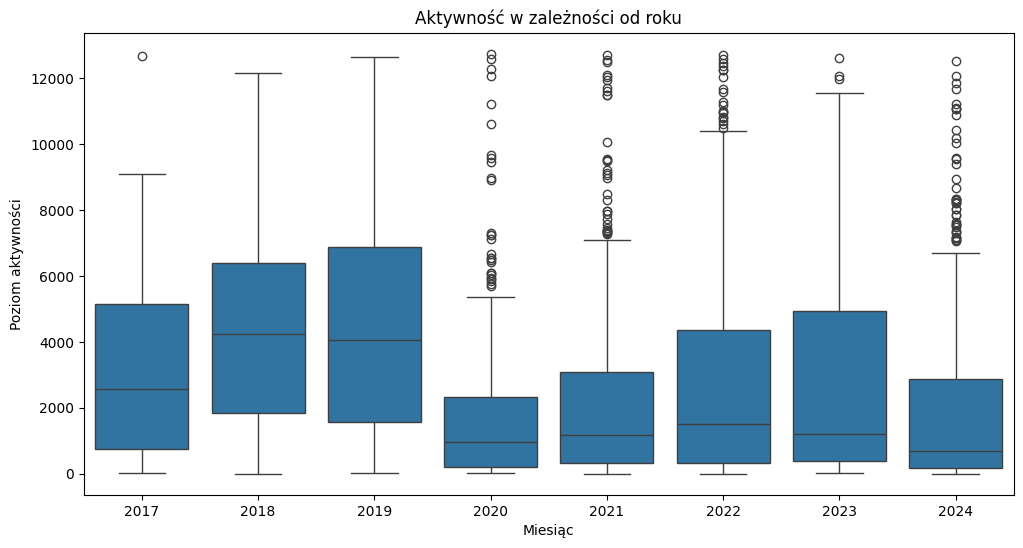

In [90]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='value', data=df)
plt.title('Aktywność w zależności od roku')
plt.xlabel('Miesiąc')
plt.ylabel('Poziom aktywności')
plt.show()

In [71]:
steps_by_month = df.groupby('month')['value'].mean().reset_index()
fig = px.line(steps_by_month, x='month', y='value', markers=True, title='Średnia liczba kroków w miesiącu')
fig.update_xaxes(title='Miesiąc', tickmode='array', tickvals=list(range(1, 13)))
fig.update_yaxes(title='Średnia liczba kroków')
fig.show()

Statystyka F: 8.3808
Wartość p: 0.00382
Odrzucamy hipotezę zerową: Średnia liczba kroków różni się pomiędzy ciepłymi i zimnymi miesiącami.


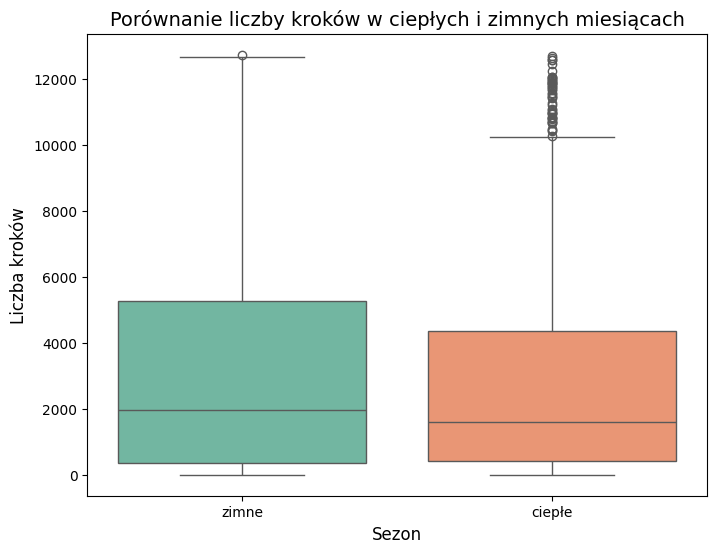

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Zakładam, że masz DataFrame df z kolumnami 'date' i 'value', gdzie 'date' to data, a 'value' to liczba kroków.

# Konwersja kolumny 'date' na typ datetime
df['date'] = pd.to_datetime(df['date'])

# Dodanie kolumny miesiąca
df['month'] = df['date'].dt.month

# Podział na ciepłe i zimne miesiące
df['season'] = df['month'].apply(lambda x: 'ciepłe' if 4 <= x <= 9 else 'zimne')

# Przeprowadzamy test ANOVA na liczbie kroków w zależności od sezonu
cieple_miesiace = df[df['season'] == 'ciepłe']['value']
zimne_miesiace = df[df['season'] == 'zimne']['value']

# Test ANOVA
anova_result = stats.f_oneway(cieple_miesiace, zimne_miesiace)

# Wyniki testu ANOVA
print(f"Statystyka F: {anova_result.statistic:.4f}")
print(f"Wartość p: {anova_result.pvalue:.5f}")

# Testowanie hipotezy
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Odrzucamy hipotezę zerową: Średnia liczba kroków różni się pomiędzy ciepłymi i zimnymi miesiącami.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: Nie ma statystycznie istotnej różnicy w liczbie kroków pomiędzy ciepłymi i zimnymi miesiącami.")

# Wizualizacja

plt.figure(figsize=(8, 6))
sns.boxplot(x='season', y='value', data=df, palette='Set2')

# Dodanie tytułu i etykiet
plt.title('Porównanie liczby kroków w ciepłych i zimnych miesiącach', fontsize=14)
plt.xlabel('Sezon', fontsize=12)
plt.ylabel('Liczba kroków', fontsize=12)

# Wyświetlenie wykresu
plt.show()

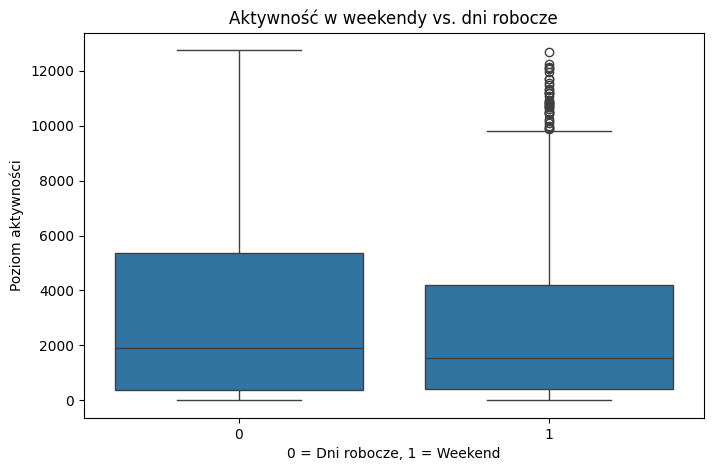

Średnia aktywność w dni robocze: 3236.96
Średnia aktywność w weekendy: 2678.89


In [76]:
# 3. Porównanie aktywności w weekendy vs. dni robocze
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_wknd', y='value', data=df)
plt.title('Aktywność w weekendy vs. dni robocze')
plt.xlabel('0 = Dni robocze, 1 = Weekend')
plt.ylabel('Poziom aktywności')
plt.show()

weekday_mean = df[df['is_wknd'] == 0]['value'].mean()
weekend_mean = df[df['is_wknd'] == 1]['value'].mean()
print(f'Średnia aktywność w dni robocze: {weekday_mean:.2f}')
print(f'Średnia aktywność w weekendy: {weekend_mean:.2f}')

In [80]:
import scipy.stats as stats

# Podział danych na dni robocze i weekendy
weekday_steps = df[df['is_wknd'] == False]['value']
weekend_steps = df[df['is_wknd'] == True]['value']

# Test normalności Shapiro-Wilka
shapiro_weekday = stats.shapiro(weekday_steps)
shapiro_weekend = stats.shapiro(weekend_steps)

print(f"Test Shapiro-Wilka dla dni roboczych: p = {shapiro_weekday.pvalue:.4f}")
print(f"Test Shapiro-Wilka dla weekendów: p = {shapiro_weekend.pvalue:.4f}")

# Wybór testu w zależności od normalności danych
if shapiro_weekday.pvalue > 0.05 and shapiro_weekend.pvalue > 0.05:
    # Test t-Studenta, jeśli dane są normalne
    t_stat, p_value = stats.ttest_ind(weekday_steps, weekend_steps, equal_var=False)
    test_used = "Test t-Studenta"
else:
    # Test Manna-Whitneya, jeśli dane nie są normalne
    t_stat, p_value = stats.mannwhitneyu(weekday_steps, weekend_steps)
    test_used = "Test Manna-Whitneya"

print(f"{test_used}: statystyka = {t_stat:.4f}, p-wartość = {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value < alpha:
    print("Różnica jest statystycznie istotna (odrzucamy H0).")
else:
    print("Brak istotnej różnicy (nie odrzucamy H0).")


Test Shapiro-Wilka dla dni roboczych: p = 0.0000
Test Shapiro-Wilka dla weekendów: p = 0.0000
Test Manna-Whitneya: statystyka = 867193.0000, p-wartość = 0.0054
Różnica jest statystycznie istotna (odrzucamy H0).


In [ ]:
df.describe()

### weather

In [25]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Zakładamy, że df to Twój DataFrame z danymi
# Grupowanie danych po miesiącach i obliczanie średnich
monthly_activity = df.groupby('month')[['temp', 'humidity', 'precipcover', 'windspeed', 
                                        'cloudcover', 'visibility', 'solarradiation', 'value']].mean().reset_index()

# Normalizacja danych przy pomocy StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(monthly_activity[['temp', 'humidity', 'precipcover', 'windspeed', 
                                                        'cloudcover', 'visibility', 'solarradiation', 'value']])

# Tworzymy DataFrame z normalizowanymi danymi
normalized_df = pd.DataFrame(normalized_data, columns=['temp', 'humidity', 'precipcover', 'windspeed', 
                                                       'cloudcover', 'visibility', 'solarradiation', 'value'])
normalized_df['month'] = monthly_activity['month']

# Tworzymy wykres
fig = go.Figure()

# Dodawanie wykresów linii dla każdej zmiennej
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['temp'], mode='lines+markers', name='Temperatura (°C)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['humidity'], mode='lines+markers', name='Wilgotność (%)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['precipcover'], mode='lines+markers', name='Pokrycie opadami (%)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['windspeed'], mode='lines+markers', name='Prędkość wiatru (km/h)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['cloudcover'], mode='lines+markers', name='Pokrycie chmur (%)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['visibility'], mode='lines+markers', name='Widoczność (km)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['solarradiation'], mode='lines+markers', name='Promieniowanie słoneczne (W/m²)'))
fig.add_trace(go.Scatter(x=normalized_df['month'], y=normalized_df['value'], mode='lines+markers', name='Liczba kroków'))

# Dostosowanie layoutu
fig.update_layout(
    title='Znormalizowane średnie wartości zmiennych pogodowych i liczby kroków w poszczególnych miesiącach',
    xaxis_title='Miesiąc',
    yaxis_title='Znormalizowana wartość',
    template='plotly_dark',
    showlegend=True,
    height=600,  # wysokość wykresu
)

# Wyświetlenie wykresu
fig.show()




In [42]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Zakładając, że df to Twój DataFrame z danymi

# Agregacja danych (wybranie odpowiednich metod agregacji dla każdej zmiennej)
monthly_activity = df.groupby('month').agg({
    'temp': 'mean',  # Średnia dla temperatury
    'humidity': 'mean',  # Średnia dla wilgotności
    'precipcover': 'median',  # Mediana dla pokrycia opadami
    'windspeed': 'mean',  # Średnia dla prędkości wiatru
    'cloudcover': 'median',  # Mediana dla pokrycia chmur
    'visibility': 'mean',  # Średnia dla widoczności
    'solarradiation': 'mean',  # Średnia dla promieniowania słonecznego
    'value': 'median'  # Mediana dla liczby kroków
}).reset_index()

# Normalizacja danych przy pomocy StandardScaler (poza miesiącem)
scaler = StandardScaler()
columns_to_normalize = ['temp', 'humidity', 'precipcover', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'value']
monthly_activity_normalized = monthly_activity.copy()

# Normalizacja tylko wartości, nie miesiąca
monthly_activity_normalized[columns_to_normalize] = scaler.fit_transform(monthly_activity[columns_to_normalize])

# Tworzymy wykres
fig = go.Figure()

# Dodawanie wykresów linii dla każdej zmiennej
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['temp'],
                         mode='lines+markers', name='Temperatura (średnia)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['humidity'],
                         mode='lines+markers', name='Wilgotność (średnia)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['precipcover'],
                         mode='lines+markers', name='Pokrycie opadami (mediana)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['windspeed'],
                         mode='lines+markers', name='Prędkość wiatru (średnia)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['cloudcover'],
                         mode='lines+markers', name='Pokrycie chmur (mediana)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['visibility'],
                         mode='lines+markers', name='Widoczność (średnia)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['solarradiation'],
                         mode='lines+markers', name='Promieniowanie słoneczne (średnia)'))
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków (mediana)'))

# Dostosowanie layoutu
fig.update_layout(
    title='Znormalizowane wartości zmiennych pogodowych i liczby kroków w poszczególnych miesiącach',
    xaxis_title='Miesiąc',
    yaxis_title='Znormalizowana wartość',
    template='plotly_dark',
    showlegend=True,
    height=600,  # wysokość wykresu
)

# Wyświetlenie wykresu
fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Zakładam, że 'monthly_activity_normalized' to DataFrame z wcześniej znormalizowanymi danymi

# Tworzymy wykres z sub-plotami (1 kolumna, 7 wierszy)
fig = make_subplots(
    rows=7, cols=1,
    subplot_titles=['Temperatura vs Miesiące', 'Wilgotność vs Miesiące',
                    'Pokrycie opadami vs Miesiące', 'Prędkość wiatru vs Miesiące',
                    'Pokrycie chmur vs Miesiące', 'Widoczność vs Miesiące',
                    'Promieniowanie słoneczne vs Miesiące'],
    shared_xaxes=True, shared_yaxes=True
)

# Dodawanie wykresów do odpowiednich subplotów
fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['temp'],
                         mode='lines+markers', name='Temperatura'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['humidity'],
                         mode='lines+markers', name='Wilgotność'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['precipcover'],
                         mode='lines+markers', name='Pokrycie opadami'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=3, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['windspeed'],
                         mode='lines+markers', name='Prędkość wiatru'),
              row=4, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=4, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['cloudcover'],
                         mode='lines+markers', name='Pokrycie chmur'),
              row=5, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=5, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['visibility'],
                         mode='lines+markers', name='Widoczność'),
              row=6, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=6, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['solarradiation'],
                         mode='lines+markers', name='Promieniowanie słoneczne'),
              row=7, col=1)

fig.add_trace(go.Scatter(x=monthly_activity_normalized['month'], y=monthly_activity_normalized['value'],
                         mode='lines+markers', name='Liczba kroków'),
              row=7, col=1)

# Dostosowanie layoutu
fig.update_layout(
    title='Porównanie zmiennych pogodowych z liczbą kroków',
    template='plotly_dark',
    showlegend=True,
    height=1800,  # Wysokość wykresu z uwagi na większą liczbę wierszy
    xaxis_title='Miesiąc',
    yaxis_title='Znormalizowana wartość',
    xaxis=dict(tickmode='array', tickvals=monthly_activity_normalized['month'])
)

# Wyświetlenie wykresu
fig.show()


In [37]:
bins_temp = [-20, 0, 10, 20, 30] 
bin_labels_temp = ['<0°C', '0-10°C', '10-20°C', '>20°C']
functions.test_weather_variable(df, 'temp', bins=bins_temp, bin_labels=bin_labels_temp)

bins_humidity = [0, 30, 60, 90] 
bin_labels_humidity = ['0-30%', '30-60%', '60-90%']
functions.test_weather_variable(df, 'humidity', bins=bins_humidity, bin_labels=bin_labels_humidity)

bins_precipcover = [0, 25, 50, 75, 100] 
bin_labels_precipcover = ['0-25%', '25-50%', '50-75%', '75-100%']
functions.test_weather_variable(df, 'precipcover', bins=bins_precipcover, bin_labels=bin_labels_precipcover)

bins_windspeed = [0, 5, 15, 25, 35] 
bin_labels_windspeed = ['0-5 km/h', '5-15 km/h', '15-25 km/h', '25-35 km/h']
functions.test_weather_variable(df, 'windspeed', bins=bins_windspeed, bin_labels=bin_labels_windspeed)

bins_cloudcover = [0, 20, 40, 60, 80, 100] 
bin_labels_cloudcover = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
functions.test_weather_variable(df, 'cloudcover', bins=bins_cloudcover, bin_labels=bin_labels_cloudcover)

bins_visibility = [0, 5, 10, 20, 50]
bin_labels_visibility = ['0-5 km', '5-10 km', '10-20 km', '20-50 km']
functions.test_weather_variable(df, 'visibility', bins=bins_visibility, bin_labels=bin_labels_visibility)

bins_solarradiation = [0, 50, 100, 150, 200, 250] 
bin_labels_solarradiation = ['0-50 W/m²', '50-100 W/m²', '100-150 W/m²', '150-200 W/m²', '200-250 W/m²']
functions.test_weather_variable(df, 'solarradiation', bins=bins_solarradiation, bin_labels=bin_labels_solarradiation)

Test Shapiro-Wilka dla grupy '0-10°C': statystyka=0.8402, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '10-20°C': statystyka=0.8208, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '<0°C': statystyka=0.8769, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '>20°C': statystyka=0.8541, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 5.29, wartość p: 0.15193
Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między grupami temp.


Test Shapiro-Wilka dla grupy '0-30%': statystyka=nan, p-wartość=nan
Test Shapiro-Wilka dla grupy '30-60%': statystyka=0.8443, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '60-90%': statystyka=0.8405, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 0.20, wartość p: 0.90276
Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między grupami humidity.


Test Shapiro-Wilka dla grupy '0-25%': statystyka=0.8479, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '25-50%': statystyka=0.7693, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '50-75%': statystyka=0.7018, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '75-100%': statystyka=0.6759, p-wartość=0.00526

Test Kruskala-Wallisa - Statystyka H: 23.35, wartość p: 0.00003
Odrzucamy hipotezę zerową: liczba kroków różni się między grupami precipcover.


Test Shapiro-Wilka dla grupy '0-5 km/h': statystyka=nan, p-wartość=nan
Test Shapiro-Wilka dla grupy '15-25 km/h': statystyka=0.8467, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '25-35 km/h': statystyka=0.7983, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '5-15 km/h': statystyka=0.8606, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 10.76, wartość p: 0.01312
Odrzucamy hipotezę zerową: liczba kroków różni się między grupami windspeed.


Test Shapiro-Wilka dla grupy '0-20%': statystyka=0.8615, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '20-40%': statystyka=0.8714, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '40-60%': statystyka=0.8430, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '60-80%': statystyka=0.8258, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '80-100%': statystyka=0.8350, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 12.78, wartość p: 0.01239
Odrzucamy hipotezę zerową: liczba kroków różni się między grupami cloudcover.


Test Shapiro-Wilka dla grupy '0-5 km': statystyka=0.8411, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '10-20 km': statystyka=0.8336, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '20-50 km': statystyka=0.8937, p-wartość=0.07627
Test Shapiro-Wilka dla grupy '5-10 km': statystyka=0.8733, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 4.54, wartość p: 0.20868
Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między grupami visibility.


Test Shapiro-Wilka dla grupy '0-50 W/m²': statystyka=0.8510, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '100-150 W/m²': statystyka=0.8255, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '150-200 W/m²': statystyka=0.8002, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '200-250 W/m²': statystyka=0.8487, p-wartość=0.00000
Test Shapiro-Wilka dla grupy '50-100 W/m²': statystyka=0.8503, p-wartość=0.00000

Test Kruskala-Wallisa - Statystyka H: 5.85, wartość p: 0.21036
Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między grupami solarradiation.


Test normalności dla wysokiej temperatury: statystyka=0.8319, p-wartość=0.00000
Test normalności dla niskiej temperatury: statystyka=0.8488, p-wartość=0.00000

Test porównujący dni z wysoką i niską temperaturą (Manna-Whitneya): statystyka=832666.0000, p-wartość=0.97352
Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między dniami z wysoką i niską temperaturą.


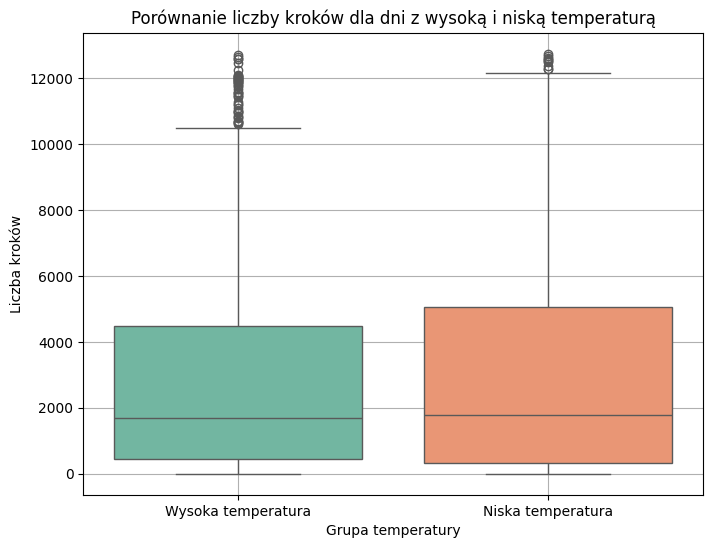

In [46]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Załóżmy, że df to Twój DataFrame z danymi
# Podzielmy dane na dwie grupy: wysoką temperaturę i niską temperaturę
median_temp = df['temp'].median()

# Wysoka temperatura: dni powyżej mediany
high_temp_days = df[df['temp'] > median_temp]

# Niska temperatura: dni poniżej mediany
low_temp_days = df[df['temp'] <= median_temp]

# Test normalności dla obu grup (test Shapiro-Wilka)
shapiro_high = stats.shapiro(high_temp_days['value'])
shapiro_low = stats.shapiro(low_temp_days['value'])

print(f"Test normalności dla wysokiej temperatury: statystyka={shapiro_high.statistic:.4f}, p-wartość={shapiro_high.pvalue:.5f}")
print(f"Test normalności dla niskiej temperatury: statystyka={shapiro_low.statistic:.4f}, p-wartość={shapiro_low.pvalue:.5f}")

# Jeśli dane są normalne, użyjemy testu t-Studenta
if shapiro_high.pvalue > 0.05 and shapiro_low.pvalue > 0.05:
    t_stat, p_value = stats.ttest_ind(high_temp_days['value'], low_temp_days['value'])
    test_type = "t-Studenta"
else:
    # Jeśli dane nie są normalne, użyjemy testu Manna-Whitneya
    t_stat, p_value = stats.mannwhitneyu(high_temp_days['value'], low_temp_days['value'], alternative='two-sided')
    test_type = "Manna-Whitneya"

print(f"\nTest porównujący dni z wysoką i niską temperaturą ({test_type}): statystyka={t_stat:.4f}, p-wartość={p_value:.5f}")

# Wyniki interpretujemy w zależności od p-wartości
alpha = 0.05
if p_value < alpha:
    print(f"Odrzucamy hipotezę zerową: liczba kroków różni się istotnie między dniami z wysoką i niską temperaturą.")
else:
    print(f"Brak podstaw do odrzucenia hipotezy zerowej: liczba kroków nie różni się istotnie między dniami z wysoką i niską temperaturą.")

# Wykres: Porównanie liczby kroków w zależności od temperatury
plt.figure(figsize=(8, 6))
sns.boxplot(x="temp_group", y="value", data=pd.concat([
    high_temp_days.assign(temp_group='Wysoka temperatura'),
    low_temp_days.assign(temp_group='Niska temperatura')
]), palette="Set2")

# Dostosowanie wykresu
plt.title('Porównanie liczby kroków dla dni z wysoką i niską temperaturą')
plt.xlabel('Grupa temperatury')
plt.ylabel('Liczba kroków')
plt.grid(True)
plt.show()


Test: Mann-Whitney U test
Statystyka testowa: 754137.0000
Wartość p: 0.00076
Odrzucamy hipotezę zerową: Pokrycie chmur ma istotny wpływ na liczbę kroków.


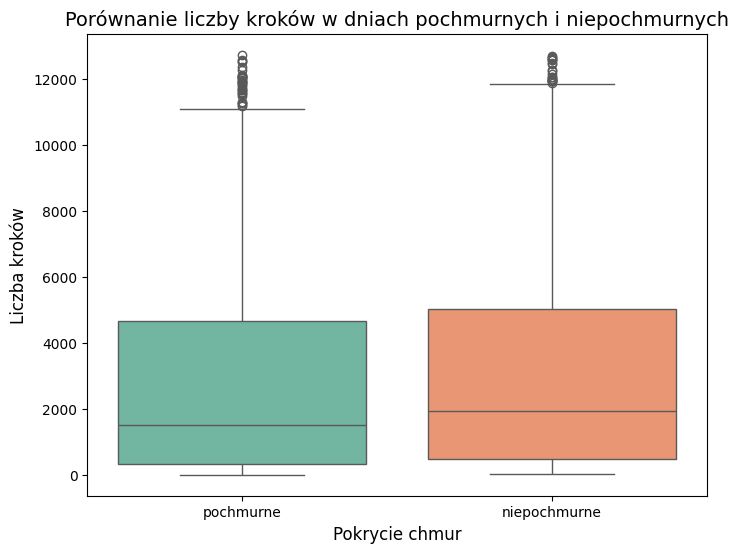

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Zakładam, że masz DataFrame df z kolumnami 'cloudcover' (pokrycie chmur) i 'value' (liczba kroków).
# Zakładając, że 'cloudcover' jest w procentach (0-100%).

# Konwersja kolumny 'cloudcover' do kategorycznych dni pochmurnych i niepochmurnych
df['cloudcover_category'] = df['cloudcover'].apply(
    lambda x: 'pochmurne' if x >= 60 else 'niepochmurne'
)

# Podzielmy dane na dni pochmurne i niepochmurne
pochmurne_dni = df[df['cloudcover_category'] == 'pochmurne']['value']
niepochmurne_dni = df[df['cloudcover_category'] == 'niepochmurne']['value']

# Przeprowadzamy test normalności Shapiro-Wilka na obu grupach (pochmurne i niepochmurne)
shapiro_pochmurne = stats.shapiro(pochmurne_dni)
shapiro_niepochmurne = stats.shapiro(niepochmurne_dni)

# Sprawdzamy, który test użyć
if shapiro_pochmurne.pvalue > 0.05 and shapiro_niepochmurne.pvalue > 0.05:
    # Test t-Studenta (dla danych o rozkładzie normalnym)
    t_stat, p_value = stats.ttest_ind(pochmurne_dni, niepochmurne_dni)
    test_name = "t-test"
else:
    # Test Manna-Whitneya (dla danych nie o rozkładzie normalnym)
    t_stat, p_value = stats.mannwhitneyu(pochmurne_dni, niepochmurne_dni, alternative='two-sided')
    test_name = "Mann-Whitney U test"

# Wyniki testu statystycznego
print(f"Test: {test_name}")
print(f"Statystyka testowa: {t_stat:.4f}")
print(f"Wartość p: {p_value:.5f}")

# Testowanie hipotezy
alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową: Pokrycie chmur ma istotny wpływ na liczbę kroków.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: Pokrycie chmur nie ma statystycznie istotnego wpływu na liczbę kroków.")

# Wizualizacja - wykres pudełkowy

plt.figure(figsize=(8, 6))
sns.boxplot(x='cloudcover_category', y='value', data=df, palette='Set2')

# Dodanie tytułu i etykiet
plt.title('Porównanie liczby kroków w dniach pochmurnych i niepochmurnych', fontsize=14)
plt.xlabel('Pokrycie chmur', fontsize=12)
plt.ylabel('Liczba kroków', fontsize=12)

# Wyświetlenie wykresu
plt.show()


Test: Mann-Whitney U test
Statystyka testowa: 782444.5000
Wartość p: 0.01663
Odrzucamy hipotezę zerową: Opady mają istotny wpływ na liczbę kroków.


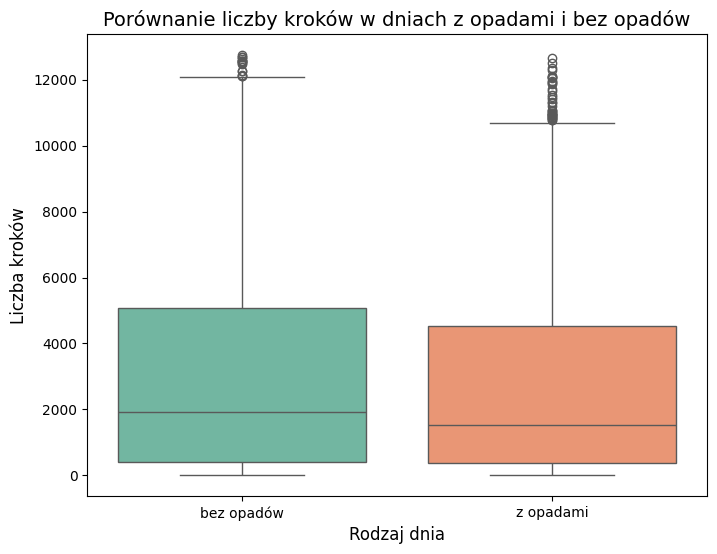

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Zakładając, że masz DataFrame df z kolumnami 'precipcover' (pokrycie opadami) i 'value' (liczba kroków)
# Możemy podzielić dane na dni z opadami i bez opadów:

# Podzielmy dane na dni z opadami i bez opadów
df['precipcover_category'] = df['precipcover'].apply(
    lambda x: 'z opadami' if x > 0 else 'bez opadów'
)

# Podzielmy dane na dni z opadami
dni_z_opadami = df[df['precipcover_category'] == 'z opadami']['value']
dni_bez_opadow = df[df['precipcover_category'] == 'bez opadów']['value']

# Sprawdzamy normalność rozkładu za pomocą testu Shapiro-Wilka
shapiro_opady = stats.shapiro(dni_z_opadami)
shapiro_bez_opadow = stats.shapiro(dni_bez_opadow)

# Testowanie rozkładu - jeśli oba rozkłady są normalne, użyjemy testu t-Studenta
if shapiro_opady.pvalue > 0.05 and shapiro_bez_opadow.pvalue > 0.05:
    # Test t-Studenta (dla danych o rozkładzie normalnym)
    t_stat, p_value = stats.ttest_ind(dni_z_opadami, dni_bez_opadow)
    test_name = "t-test"
else:
    # Test Manna-Whitneya (dla danych nie o rozkładzie normalnym)
    t_stat, p_value = stats.mannwhitneyu(dni_z_opadami, dni_bez_opadow, alternative='two-sided')
    test_name = "Mann-Whitney U test"

# Wyniki testu statystycznego
print(f"Test: {test_name}")
print(f"Statystyka testowa: {t_stat:.4f}")
print(f"Wartość p: {p_value:.5f}")

# Testowanie hipotezy
alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową: Opady mają istotny wpływ na liczbę kroków.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: Opady nie mają statystycznie istotnego wpływu na liczbę kroków.")

# Wizualizacja - wykres pudełkowy

plt.figure(figsize=(8, 6))
sns.boxplot(x='precipcover_category', y='value', data=df, palette='Set2')

# Dodanie tytułu i etykiet
plt.title('Porównanie liczby kroków w dniach z opadami i bez opadów', fontsize=14)
plt.xlabel('Rodzaj dnia', fontsize=12)
plt.ylabel('Liczba kroków', fontsize=12)

# Wyświetlenie wykresu
plt.show()


# Modelling

Modelowanie: Zdecyduj, czy problem to klasyfikacja, czy regresja. Wykorzystaj odpowiednie modele uczenia
maszynowego (np. drzewa decyzyjne, regresję logistyczną dla klasyfikacji; regresję liniową, lasy losowe dla regresji) z
biblioteki `
scikit-learn
` i oceń ich wyniki przy użyciu takich miar jak dokładność (accuracy), F1 score lub R-kwadrat
(R²), w zależności od typu danych i analizy.

In [274]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [188]:
def create_features(df):
    """Funkcja do tworzenia cech czasowych, lagów i średnich kroczących"""
    df = df.copy()
    
    # # Cechy czasowe
    # df["day_of_week"] = df.index.dayofweek
    # df["month"] = df.index.month
    # df["year"] = df.index.year
    # df["day_of_year"] = df.index.dayofyear
    # df["weekofyear"] = df.index.isocalendar().week
    # df["quarter"] = df.index.quarter
    # df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # Lagowane wartości
    for lag in [1, 7, 14, 21]:
        df[f"value_lag_{lag}"] = df["value"].shift(lag)

    # Średnie kroczące
    for window in [3, 7, 14, 21]:
        df[f"value_roll_mean_{window}"] = df["value"].rolling(window).mean()
    
    return df

df = create_features(df)
df.dropna(inplace=True)
df

value  month  year  day_of_week  is_wknd  temp  humidity  \
date                                                                    
2018-01-29  5809.0      1  2018            1        0   7.9      88.2   
2018-01-30  2360.0      1  2018            2        0   4.7      77.1   
2018-01-31  4986.0      1  2018            3        0   3.6      72.9   
2018-02-01  7769.0      2  2018            4        0   4.2      88.5   
2018-02-02  3401.0      2  2018            5        1   1.8      92.9   
...            ...    ...   ...          ...      ...   ...       ...   
2024-12-27    73.0     12  2024            5        1   1.1      97.8   
2024-12-28   230.0     12  2024            6        1   0.8      97.9   
2024-12-29    41.0     12  2024            7        1   2.2      96.4   
2024-12-30   169.0     12  2024            1        0   0.9      96.8   
2024-12-31   749.0     12  2024            2        0   1.1      92.0   

            precipcover  windspeed  cloudcover  ...  value_lag_1  value_lag_7  \
date                                            ...                             
2018-01-29         8.33       27.7        93.1  ...        500.0        158.0   
2018-01-30         8.33       42.9        86.1  ...       5809.0        124.0   
2018-01-31         0.00       20.0        72.3  ...       2360.0        268.0   
2018-02-01         8.33       15.4        92.7  ...       4986.0        161.0   
2018-02-02         4.17       14.8        84.4  ...       7769.0        458.0   
...                 ...        ...         ...  ...          ...          ...   
2024-12-27         0.00        8.4        99.1  ...        638.0         44.0   
2024-12-28         0.00        7.4       100.0  ...         73.0       8939.0   
2024-12-29         0.00       18.5        86.4  ...        230.0       7078.0   
2024-12-30         0.00       23.4       100.0  ...         41.0        202.0   
2024-12-31         0.00       27.4        76.3  ...        169.0        702.0   

            value_lag_30  value_roll_mean_3  value_roll_mean_7  \
date                                                             
2018-01-29       12680.0        2156.000000        1068.428571   
2018-01-30        5456.0        2889.666667        1387.857143   
2018-01-31        9332.0        4385.000000        2061.857143   
2018-02-01       10289.0        5038.333333        3148.714286   
2018-02-02        8645.0        5385.333333        3569.142857   
...                  ...                ...                ...   
2024-12-27        4729.0         395.000000        2586.571429   
2024-12-28        3276.0         313.666667        1342.428571   
2024-12-29        4991.0         114.666667         337.142857   
2024-12-30         189.0         146.666667         332.428571   
2024-12-31        1851.0         319.666667         339.142857   

            value_roll_mean_30  value_lag_14  value_lag_21  \
date                                                         
2018-01-29         3202.366667         167.0        6081.0   
2018-01-30         3099.166667         243.0        2960.0   
2018-01-31         2954.300000        2884.0        7579.0   
2018-02-01         2870.300000        1450.0        8835.0   
2018-02-02         2695.500000          97.0        4635.0   
...                        ...           ...           ...   
2024-12-27         2690.966667         163.0          60.0   
2024-12-28         2589.433333        7549.0        7852.0   
2024-12-29         2424.433333         193.0        7483.0   
2024-12-30         2423.766667        1830.0         813.0   
2024-12-31         2387.033333          86.0         144.0   

            value_roll_mean_14  value_roll_mean_21  
date                                                
2018-01-29          933.642857         2004.523810  
2018-01-30         1084.857143         1975.952381  
2018-01-31         1235.000000         1852.476190  
2018-02-01         1686.357143         1801.714286  
2018-02-02         1922.3

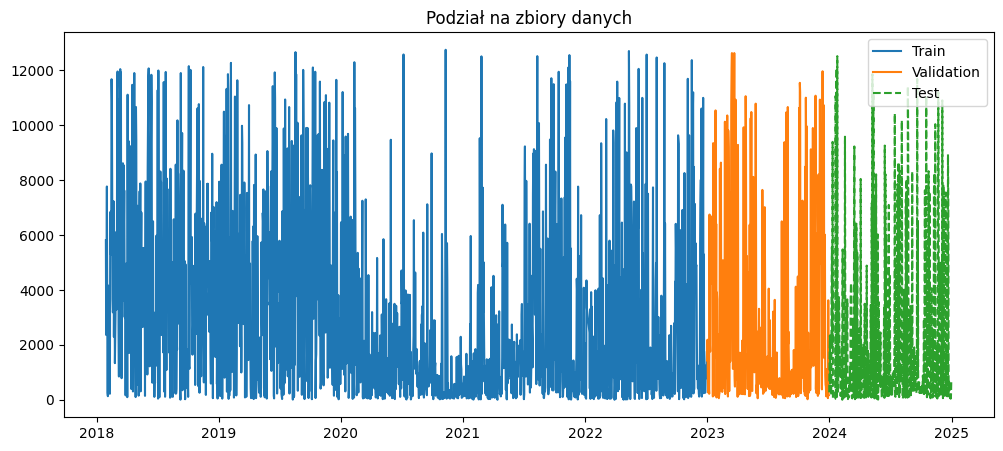

In [189]:

# Podział danych
train = df.loc[:'2022-12-31']
val = df.loc['2023-01-01':'2023-12-31']
test = df.loc['2024-01-01':]

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(test.index, test['value'], label="Test", linestyle="dashed")
plt.legend()
plt.title("Podział na zbiory danych")
plt.show()


/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/zuzannagez/miniconda3/envs/pad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



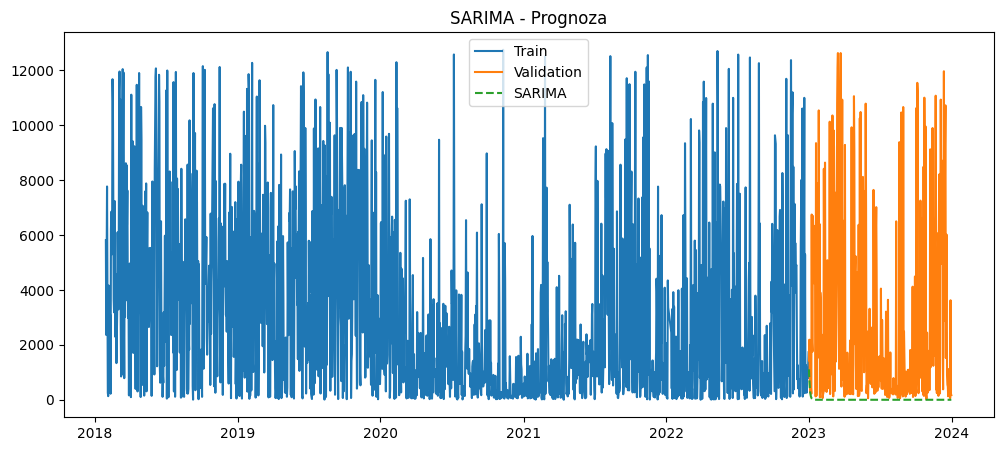

SARIMA RMSE: 4480.33
SARIMA MAE: 2945.65
SARIMA R²: -0.77


In [237]:
sarima_model = SARIMAX(train['value'])
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.predict(start=val.index[0], end=val.index[-1])

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(val.index, sarima_pred, label="SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA - Prognoza")
plt.show()

# Metryki
rmse_sarima = np.sqrt(mean_squared_error(val['value'], sarima_pred))
mae_sarima = mean_absolute_error(val['value'], sarima_pred)
r2_sarima = r2_score(val['value'], sarima_pred)

print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA R²: {r2_sarima:.2f}")


10:30:01 - cmdstanpy - INFO - Chain [1] start processing
10:30:01 - cmdstanpy - INFO - Chain [1] done processing


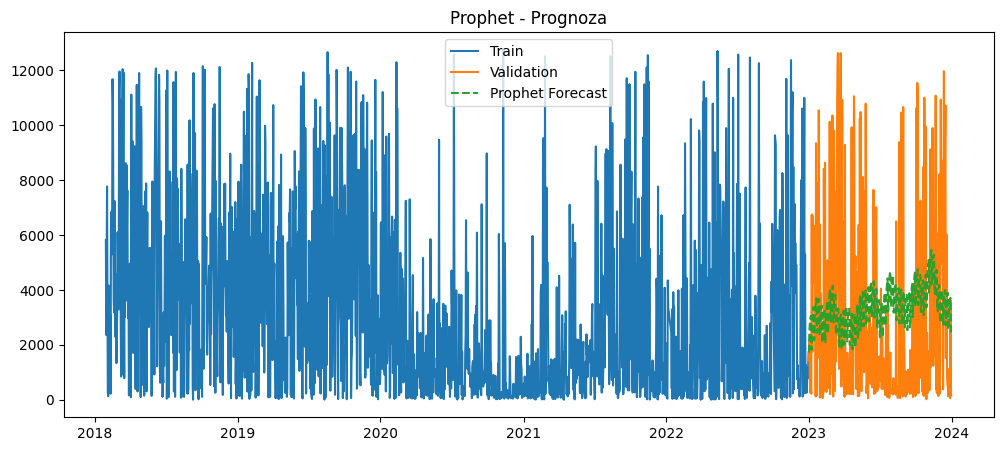

Prophet RMSE: 3439.41
Prophet MAE: 2948.89
Prophet R²: -0.04


In [216]:

# Przygotowanie danych do Prophet
df_prophet = train[['value']].reset_index().rename(columns={"date": "ds", "value": "y"})

# Trenowanie modelu Prophet
prophet_model = Prophet( weekly_seasonality=True)
prophet_model.fit(df_prophet)

# Prognoza
future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
forecast = prophet_model.predict(future)

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(future['ds'], forecast['yhat'], label="Prophet Forecast", linestyle="dashed")
plt.legend()
plt.title("Prophet - Prognoza")
plt.show()

# Metryki
rmse_prophet = np.sqrt(mean_squared_error(val['value'], forecast.loc[forecast['ds'].isin(val.index), 'yhat']))
mae_prophet = mean_absolute_error(val['value'], forecast.loc[forecast['ds'].isin(val.index), 'yhat'])
r2_prophet = r2_score(val['value'], forecast.loc[forecast['ds'].isin(val.index), 'yhat'])

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet:.2f}")

# zmienne dodatkowe

In [217]:
# Zmienne dodatkowe
exog_features = ['month', 'year', 'day_of_week', 'is_wknd', 'temp', 'humidity',
       'precipcover', 'windspeed', 'cloudcover', 'visibility',
       'solarradiation', 'value_lag_1', 'value_lag_7', 'value_lag_30',
       'value_roll_mean_3', 'value_roll_mean_7', 'value_roll_mean_30',
       'value_lag_14', 'value_lag_21', 'value_roll_mean_14',
       'value_roll_mean_21']

In [252]:
import time

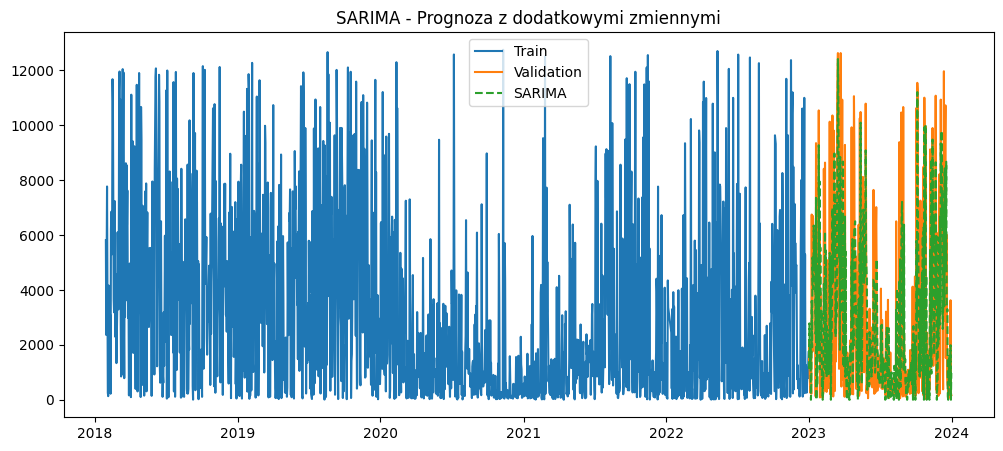

SARIMA RMSE: 2069.65
SARIMA MAE: 1488.84
SARIMA R²: 0.62
SARIMA MAPE: 284.60


In [253]:
start_time = time.time()

sarima_model = SARIMAX(train['value'], exog=train[exog_features])
sarima_fit = sarima_model.fit()

end_time = time.time()
sarima_training_time = end_time - start_time

sarima_pred = sarima_fit.predict(start=val.index[0], end=val.index[-1], exog=val[exog_features])
sarima_pred[sarima_pred < 0] = 0

# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(val.index, sarima_pred, label="SARIMA", linestyle="dashed")
plt.legend()
plt.title("SARIMA - Prognoza z dodatkowymi zmiennymi")
plt.show()

# Metryki
rmse_sarima = np.sqrt(mean_squared_error(val['value'], sarima_pred))
mae_sarima = mean_absolute_error(val['value'], sarima_pred)
r2_sarima = r2_score(val['value'], sarima_pred)
mape_sarima = mean_absolute_percentage_error(val['value'], sarima_pred) * 100

print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA R²: {r2_sarima:.2f}")
print(f"SARIMA MAPE: {mape_sarima:.2f}")


11:01:24 - cmdstanpy - INFO - Chain [1] start processing
11:01:24 - cmdstanpy - INFO - Chain [1] done processing


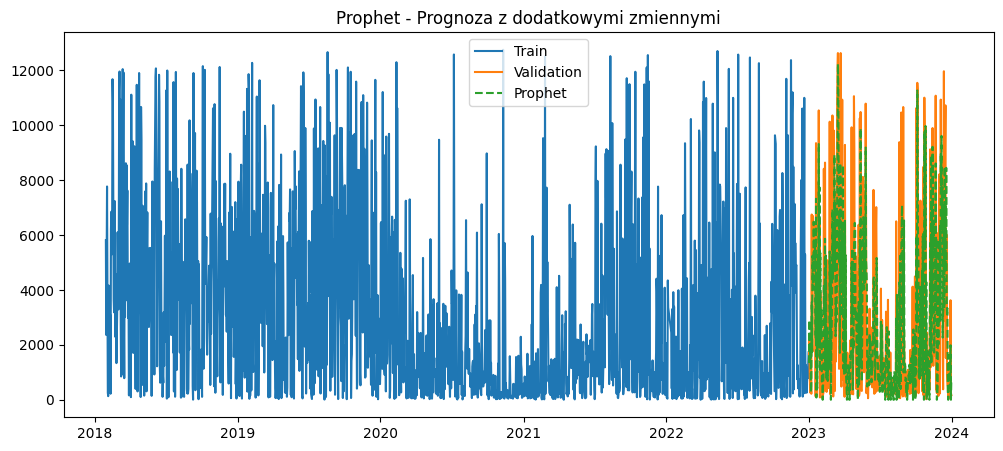

Prophet RMSE: 2057.67
Prophet MAE: 1482.19
Prophet R²: 0.63
Prophet MAPE: 277.42


In [254]:
df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
start_time = time.time()

prophet_model = Prophet(weekly_seasonality=True)

# Dodanie zmiennych dodatkowych
for col in exog_features:
    prophet_model.add_regressor(col)

prophet_model.fit(df_prophet)
end_time = time.time()
prophet_training_time = end_time - start_time

future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = val[col].values

forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0
# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(val.index, forecast['yhat'], label="Prophet", linestyle="dashed")
plt.legend()
plt.title("Prophet - Prognoza z dodatkowymi zmiennymi")
plt.show()

rmse_prophet = np.sqrt(mean_squared_error(val['value'], forecast['yhat']))
mae_prophet = mean_absolute_error(val['value'], forecast['yhat'])
r2_prophet = r2_score(val['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(val['value'], forecast['yhat']) * 100

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}")

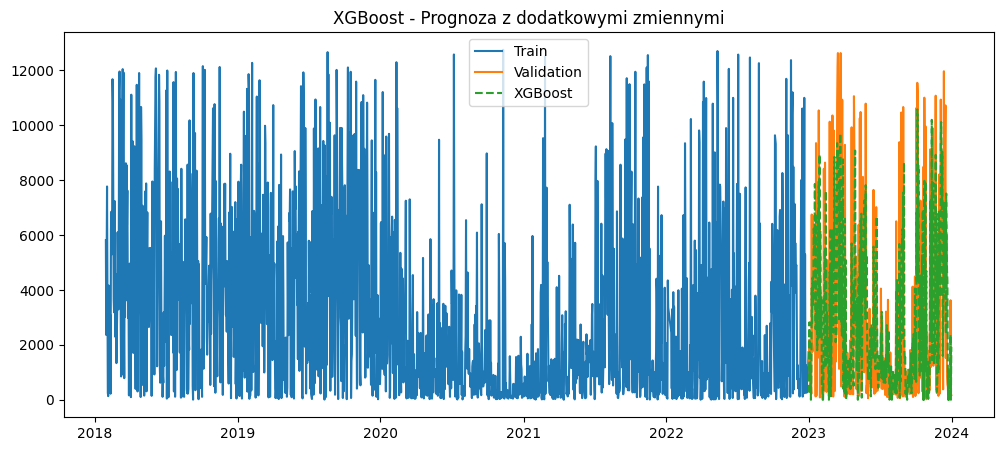

XGBoost RMSE: 2321.38
XGBoost MAE: 1659.64
XGBoost R²: 0.53
XGBoost MAPE: 308.23


In [255]:
from xgboost import XGBRegressor
# Przygotowanie danych do XGBoost
X_train = train[exog_features]
y_train = train['value']
X_val = val[exog_features]
y_val = val['value']
#n_estimators=500, learning_rate=0.01, max_depth=5
start_time = time.time()
model_xgb = XGBRegressor()
# model_xgb = XGBRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0)
model_xgb.fit(X_train, y_train)
end_time = time.time()
xgb_training_time = end_time - start_time
# Prognoza
val_pred_xgb = model_xgb.predict(X_val)
val_pred_xgb[val_pred_xgb < 0] = 0
# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(val.index, val_pred_xgb, label="XGBoost", linestyle="dashed")
plt.legend()
plt.title("XGBoost - Prognoza z dodatkowymi zmiennymi")
plt.show()

rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
mae_xgb = mean_absolute_error(y_val, val_pred_xgb)
r2_xgb = r2_score(y_val, val_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_val, val_pred_xgb) * 100

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")
print(f"XGBoost MAPE: {mape_xgb:.2f}")

     Model         RMSE          MAE     R² [%]    MAPE (%)  Training Time (s)
0   SARIMA  2069.651965  1488.839824  62.318162  284.600297           8.007739
1  Prophet  2057.672576  1482.186751  62.753113  277.423923           0.167717
2  XGBoost  2321.384826  1659.643291  52.594174  308.234249           0.135987


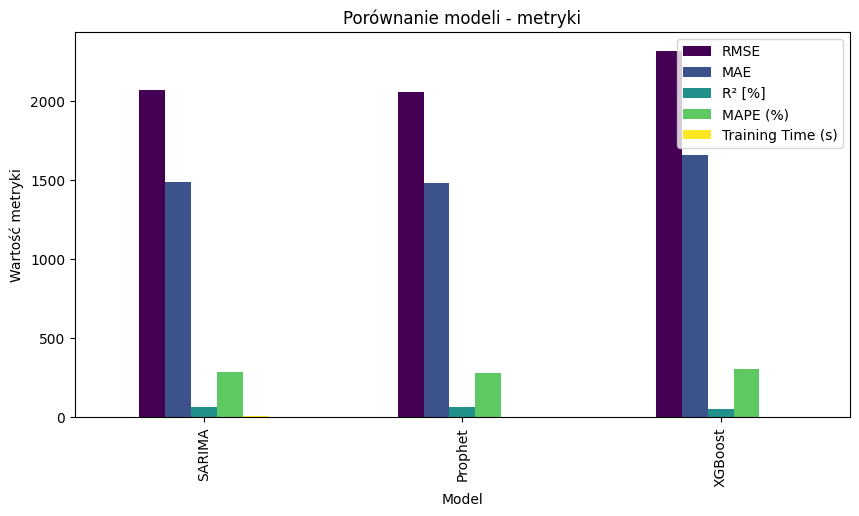

In [256]:
# Zbieranie wyników
results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet","XGBoost"],
    "RMSE": [ rmse_sarima, rmse_prophet,  rmse_xgb],
    "MAE": [ mae_sarima, mae_prophet,  mae_xgb],
    "R² [%]": [ r2_sarima * 100, r2_prophet * 100,  r2_xgb * 100],
    "MAPE (%)": [ mape_sarima, mape_prophet,  mape_xgb],
    'Training Time (s)': [sarima_training_time, prophet_training_time, xgb_training_time]
})

print(results)

# Wizualizacja wyników
results.set_index("Model").plot(kind="bar", figsize=(10,5), colormap="viridis")
plt.title("Porównanie modeli - metryki")
plt.ylabel("Wartość metryki")
plt.show()


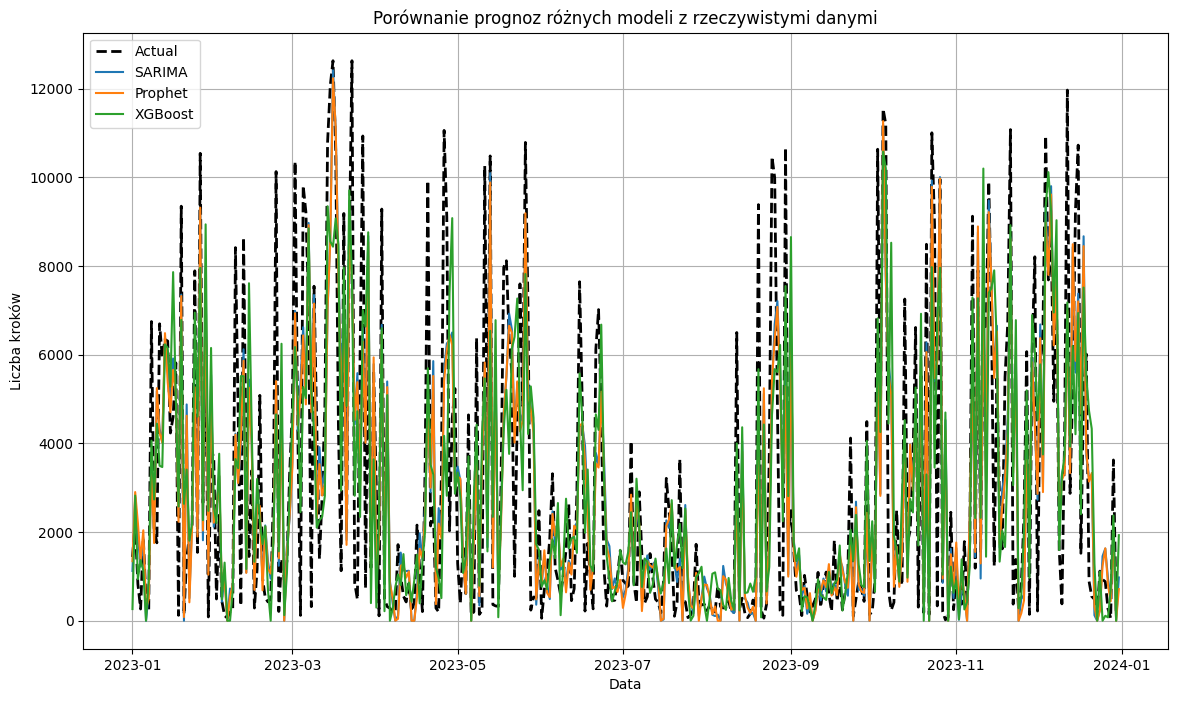

In [257]:
import matplotlib.pyplot as plt
import numpy as np

# Załóżmy, że masz prognozy dla każdego modelu, na przykład:
# - seasonal_naive_pred: Prognozy dla Seasonal Naïve
# - sarima_pred: Prognozy dla SARIMA
# - forecast['yhat'].values: Prognozy dla Prophet
# - forecast_nbeats["NBEATS"].values: Prognozy dla N-BEATS
# - val_pred_xgb: Prognozy dla XGBoost

# Ręczne stworzenie słownika z prognozami
forecast_values = {
    "SARIMA": sarima_pred.values,  # Prognoza dla SARIMA
    "Prophet": forecast['yhat'].values,  # Prognoza dla Prophet (z 'forecast')
    "XGBoost": val_pred_xgb  # Prognoza dla XGBoost
}

# Tworzymy wykres
plt.figure(figsize=(14, 8))

# Dodajemy rzeczywiste dane na wykres
plt.plot(val.index, val['value'], label='Actual', color='black', linewidth=2, linestyle='--')

# Tworzymy wykres dla wszystkich prognoz w jednym
for model, forecast_data in forecast_values.items():
    if isinstance(forecast_data, (np.ndarray, list)):  # Upewniamy się, że prognoza jest w odpowiednim formacie
        plt.plot(val.index, forecast_data, label=model)

# Dostosowanie wykresu
plt.title("Porównanie prognoz różnych modeli z rzeczywistymi danymi")
plt.xlabel("Data")
plt.ylabel("Liczba kroków")
plt.legend()
plt.grid(True)

# Pokazujemy wykres
plt.show()




# selekcja modleu i ostrajenie  - prophet

In [ ]:
import pandas as pd
import numpy as np
import optuna

df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})

df_prophet['cap'] = 12000  # Przykładowa wartość maksymalna dla serii czasowej


# Funkcja optymalizacji hiperparametrów dla Optuna
def objective(trial):
    # Przestrzeń hiperparametrów
    growth = trial.suggest_categorical('growth', ['linear', 'logistic'])
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Tworzenie modelu Prophet
    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        growth=growth,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )

    # Dla wzrostu 'logistic' dodaj kolumnę 'cap'
    if growth == 'logistic':
        df_prophet['cap'] = 12000  # Ustalona maksymalna wartość prognozy

    # Dopasowanie modelu
    model.fit(df_prophet)

    # Tworzenie przyszłych dat z limitem (jeśli logistic)
    future = model.make_future_dataframe(periods=90)
    if growth == 'logistic':
        future['cap'] = 12000

    # Prognozowanie
    forecast = model.predict(future)

    # Ocena modelu (porównanie rzeczywistych i prognozowanych wartości)
    y_true = df_prophet['y'].values
    y_pred = forecast['yhat'].iloc[:len(y_true)].values

    # Metryka oceny – MAPE
    mape_value = mean_absolute_error(y_true, y_pred)
    return mape_value

# Uruchomienie procesu optymalizacji
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Wyświetlenie najlepszych wyników
print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)



[I 2025-01-24 11:18:19,280] A new study created in memory with name: no-name-88c65593-1e51-4a91-9e15-0b7b09e00903
11:18:19 - cmdstanpy - INFO - Chain [1] start processing
11:18:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-01-24 11:18:19,680] Trial 0 finished with value: 2366.7352103892003 and parameters: {'growth': 'linear', 'changepoint_prior_scale': 0.0017367951457029156, 'seasonality_prior_scale': 0.026378756410502944, 'holidays_prior_scale': 0.01778439551850943, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 2366.7352103892003.
11:18:19 - cmdstanpy - INFO - Chain [1] start processing
11:18:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-01-24 11:18:20,773] Trial 1 finished with value: 2317.8754891255744 and parameters: {'growth': 'logistic', 'changepoint_prior_scale': 0.16988965947559054, 'seasonality_prior_scale': 8.82077272968717, 'holidays_prior_scale': 0.05539309078151894, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 2317.875

Best parameters: {'growth': 'linear', 'changepoint_prior_scale': 0.49092791106685507, 'seasonality_prior_scale': 0.20685962523143397, 'holidays_prior_scale': 1.1345665871925479, 'seasonality_mode': 'multiplicative'}
Best MAPE: 2163.650042812236


In [ ]:
# MAE

#MAPE
growth='linear', changepoint_prior_scale= 0.496217691321094, seasonality_prior_scale= 0.8120275934521926, holidays_prior_scale= 7.9161707668002705, seasonality_mode='multiplicative'


growth='linear', changepoint_prior_scale= 0.3357025380619355, seasonality_prior_scale=0.3936767736046756, holidays_prior_scale=1.9731508947227492, seasonality_mode= 'multiplicative'}
Best MAPE: 9.913534419412974

11:38:32 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1] done processing


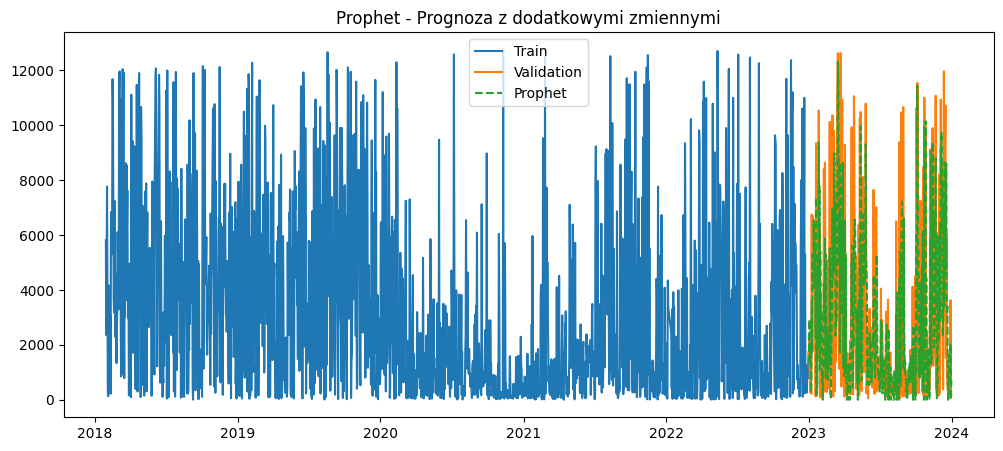

Prophet RMSE: 2058.14
Prophet MAE: 1489.22
Prophet R²: 0.63
Prophet MAPE: 286.60


In [287]:
df_prophet = train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})
start_time = time.time()

prophet_model = Prophet(weekly_seasonality=True, 
                        yearly_seasonality=True,growth='linear', changepoint_prior_scale= 0.3357025380619355, seasonality_prior_scale=0.3936767736046756, holidays_prior_scale=1.9731508947227492, seasonality_mode= 'multiplicative'
                        #growth='linear', change
                        # oint_prior_scale= 0.496217691321094, seasonality_prior_scale= 0.8120275934521926, holidays_prior_scale= 7.9161707668002705, seasonality_mode='multiplicative'
)

# Dodanie zmiennych dodatkowych
for col in exog_features:
    prophet_model.add_regressor(col)

prophet_model.fit(df_prophet)
end_time = time.time()
prophet_training_time = end_time - start_time

future = pd.DataFrame(pd.date_range(start=val.index.min(), end=val.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = val[col].values

forecast = prophet_model.predict(future)
forecast[forecast['yhat'] < 0] = 0
# Wizualizacja
plt.figure(figsize=(12,5))
plt.plot(train.index, train['value'], label="Train")
plt.plot(val.index, val['value'], label="Validation")
plt.plot(val.index, forecast['yhat'], label="Prophet", linestyle="dashed")
plt.legend()
plt.title("Prophet - Prognoza z dodatkowymi zmiennymi")
plt.show()

rmse_prophet = np.sqrt(mean_squared_error(val['value'], forecast['yhat']))
mae_prophet = mean_absolute_error(val['value'], forecast['yhat'])
r2_prophet = r2_score(val['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(val['value'], forecast['yhat']) * 100

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}")

# TEST

11:37:36 - cmdstanpy - INFO - Chain [1] start processing
11:37:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 2108.91
Prophet MAE: 1438.12
Prophet R²: 51.13%
Prophet MAPE: 6.86%
Prophet Training Time: 0.27 seconds


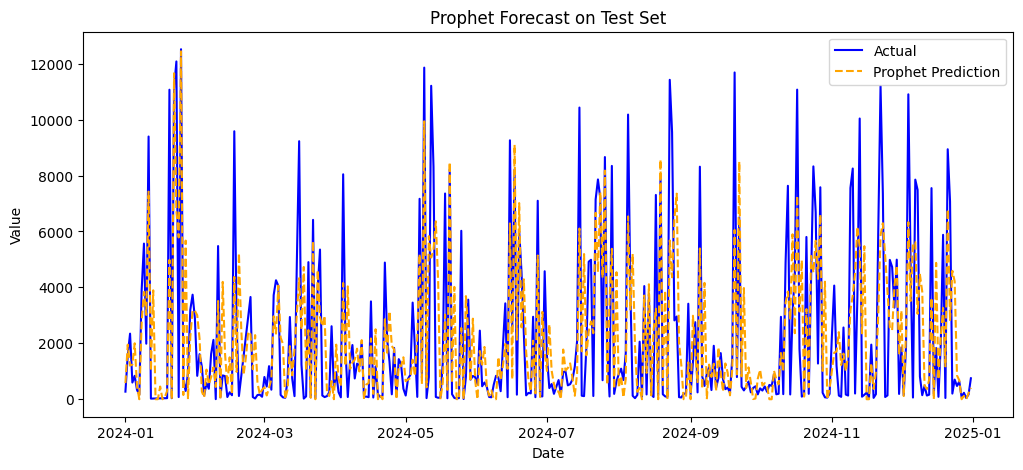

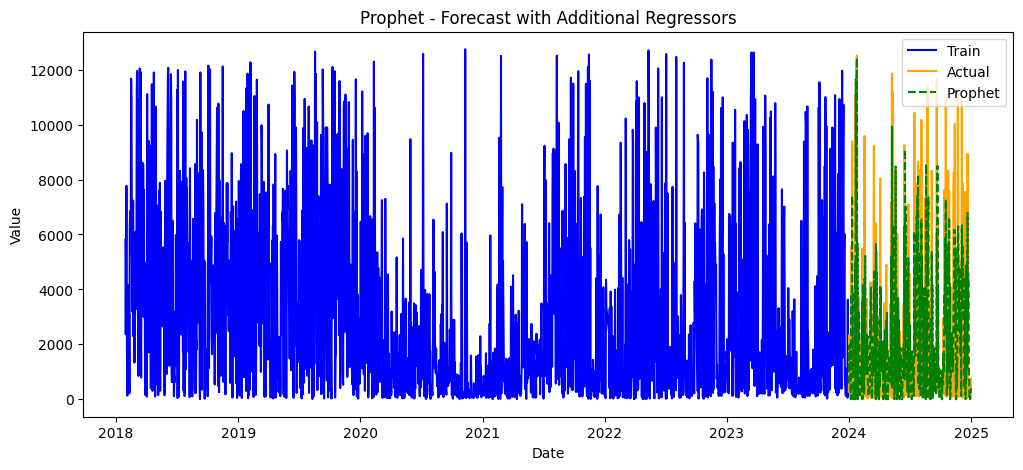

Prophet RMSE: 2108.91
Prophet MAE: 1438.12
Prophet R²: 51.13%
Prophet MAPE: 6.86%
Prophet Training Time: 0.27 seconds


In [ ]:
full_train = pd.concat([train, val])
df_prophet = full_train[['value'] + exog_features].reset_index().rename(columns={"date": "ds", "value": "y"})

# Trenowanie modelu Prophet
start_time = time.time()

prophet_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    growth='linear',
    changepoint_prior_scale=0.3357025380619355,
    seasonality_prior_scale=0.3936767736046756,
    holidays_prior_scale=1.9731508947227492,
    seasonality_mode='multiplicative'
)

# Dodanie zmiennych dodatkowych (regresorów)
for col in exog_features:
    prophet_model.add_regressor(col)

prophet_model.fit(df_prophet)
end_time = time.time()
prophet_training_time = end_time - start_time

# Tworzenie przyszłych dat dla zbioru testowego
future = pd.DataFrame(pd.date_range(start=test.index.min(), end=test.index.max(), freq='D'), columns=["ds"])
for col in exog_features:
    future[col] = test[col].values

# Prognoza Prophet
forecast = prophet_model.predict(future)
forecast['yhat'] = np.maximum(forecast['yhat'], 0)  # Zamiana wartości ujemnych na 0

# Metryki dla Prophet
rmse_prophet = np.sqrt(mean_squared_error(test['value'], forecast['yhat']))
mae_prophet = mean_absolute_error(test['value'], forecast['yhat'])
r2_prophet = r2_score(test['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(test['value'], forecast['yhat'])

# Wyniki metryk
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet * 100:.2f}%")
print(f"Prophet MAPE: {mape_prophet:.2f}%")
print(f"Prophet Training Time: {prophet_training_time:.2f} seconds")

# Wizualizacja 1: Prognoza Prophet na zbiorze testowym
plt.figure(figsize=(12, 5))
plt.plot(test.index, test['value'], label="Actual", color='blue')
plt.plot(test.index, forecast['yhat'], label="Prophet Prediction", linestyle="dashed", color='orange')
plt.legend()
plt.title("Prophet Forecast on Test Set")
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Wizualizacja 2: Porównanie danych rzeczywistych z prognozami na zbiorze treningowym i walidacyjnym
plt.figure(figsize=(12, 5))
plt.plot(full_train.index, full_train['value'], label="Train", color='blue')
plt.plot(test.index, test['value'], label="Actual", color='orange')
plt.plot(test.index, forecast['yhat'], label="Prophet", linestyle="dashed", color='green')
plt.legend()
plt.title("Prophet - Forecast with Additional Regressors")
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Metryki dla Prophet
rmse_prophet = np.sqrt(mean_squared_error(test['value'], forecast['yhat']))
mae_prophet = mean_absolute_error(test['value'], forecast['yhat'])
r2_prophet = r2_score(test['value'], forecast['yhat'])
mape_prophet = mean_absolute_percentage_error(test['value'], forecast['yhat'])

# Wyniki metryk
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet R²: {r2_prophet * 100:.2f}%")
print(f"Prophet MAPE: {mape_prophet:.2f}%")
print(f"Prophet Training Time: {prophet_training_time:.2f} seconds")


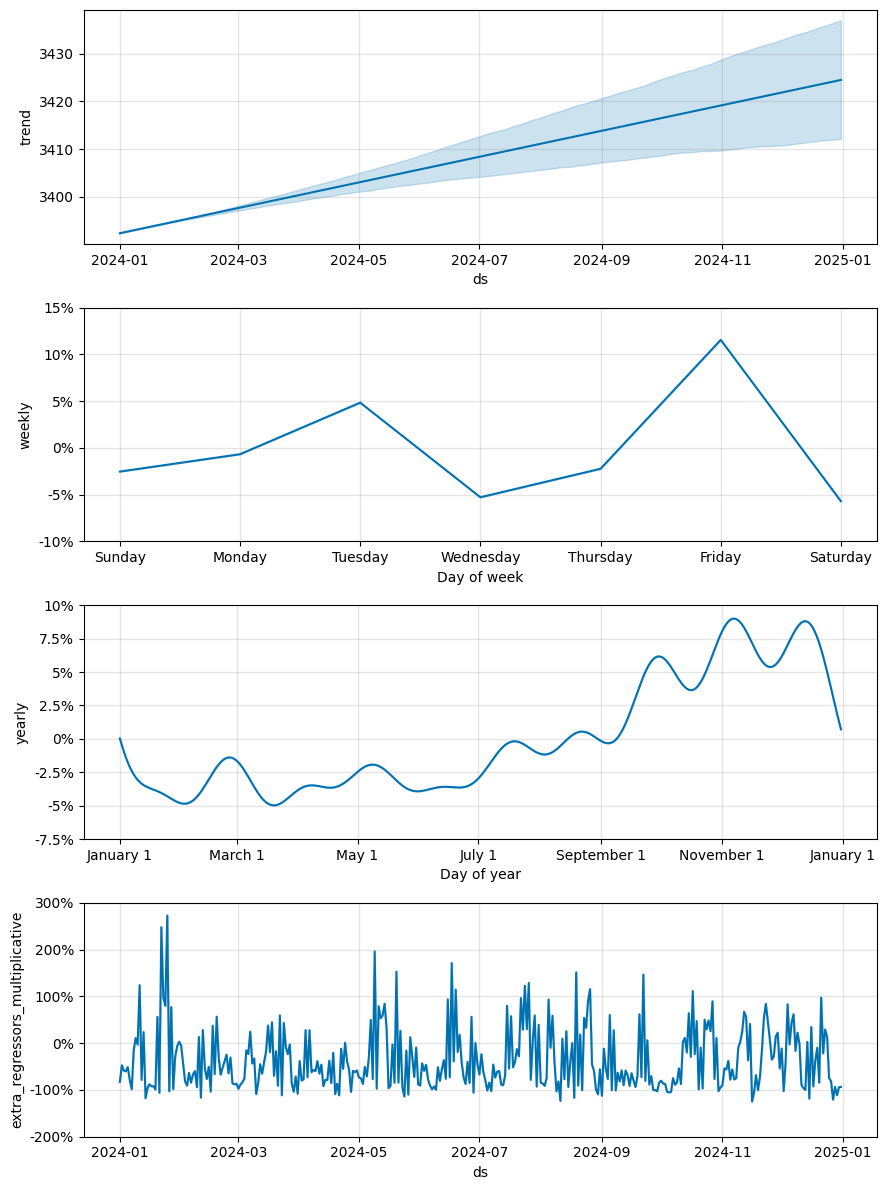

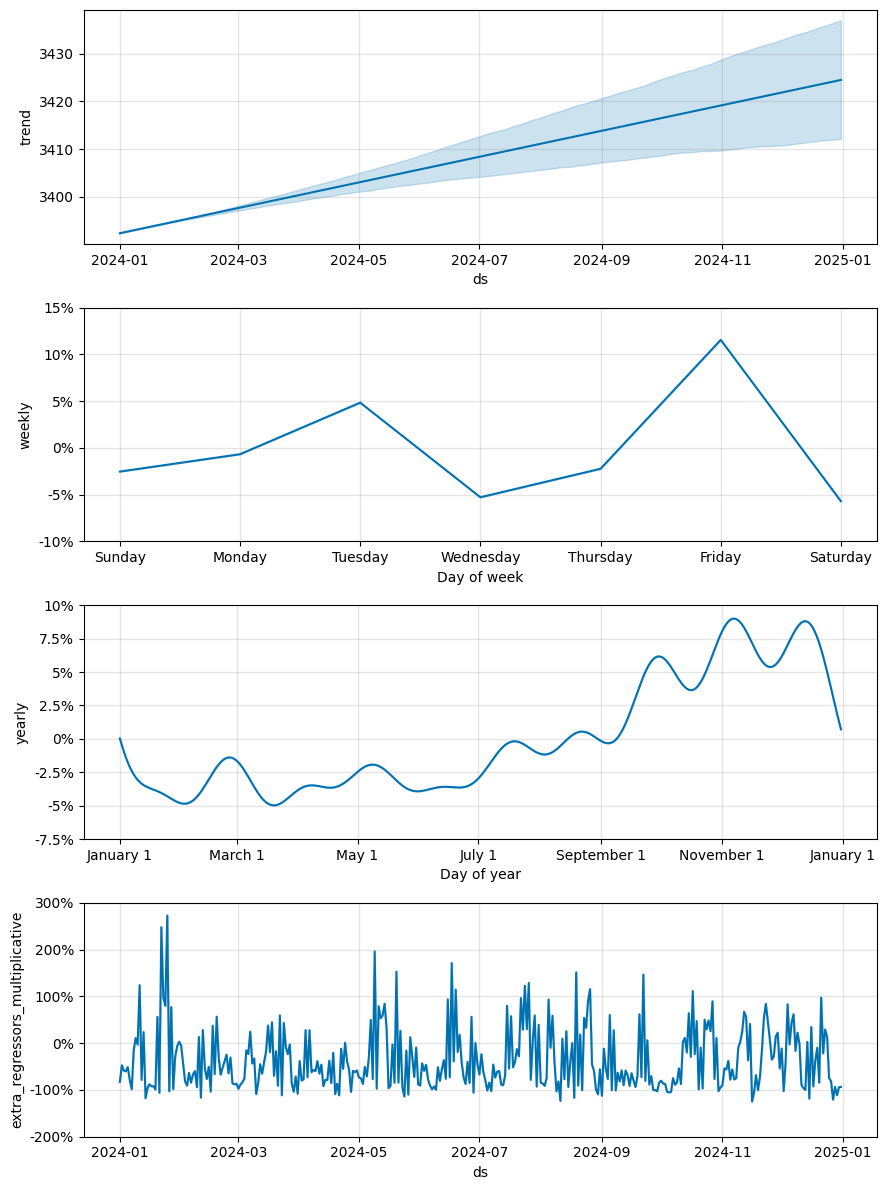

In [283]:
prophet_model.plot_components(forecast)